In [1]:
import logging
import matplotlib.pyplot as plt

from analyzer import GaiaAnalyzer
from analyzer import MISTFitter, BinaryMixtureFitter
from downloader import LightCurveExtractor

%load_ext autoreload
%autoreload 2

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
# some statements to make the figures look nicer 
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 10, 
                     'ytick.labelsize': 10,
                     'axes.labelsize': 12,
                    
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6)
                    })

In [3]:
gaia_analyzer = GaiaAnalyzer(filename='gaia.csv')
gaia_analyzer.get_data()

df = gaia_analyzer.get_data().copy()
df.head()

,source_id,ra,dec,parallax,parallax_unc,pmra,pmra_error,pmdec,pmdec_error,G_mag,...,logg,logg_gspspec_lower,logg_gspspec_upper,phot_bp_rp,BP_mag_unc,RP_mag_unc,G_mag_unc,teff_unc,logg_unc,distance_unc
0,3763976194792448,45.276791,5.006404,7.954515,0.019097,24.526128,0.023404,-45.727224,0.017959,9.279200,...,3.95,3.78,4.06,0.720543,0.000650,0.000533,0.000192,2.645996,0.14,0.308952
1,11352324413414016,52.860503,7.796339,8.422533,0.035354,24.168420,0.050407,-50.147355,0.035200,13.830488,...,NaN,NaN,NaN,2.155826,0.001755,0.000591,0.000444,4.344116,NaN,3.102100
2,19817739313090688,39.568739,7.965070,12.499952,0.160662,43.608250,0.172182,-71.069385,0.178885,18.442486,...,NaN,NaN,NaN,0.715567,0.035904,0.030820,0.002122,NaN,NaN,NaN
3,43733079289895424,56.558523,17.154376,18.583617,0.023517,49.660663,0.026018,-111.754468,0.019403,12.016204,...,NaN,NaN,NaN,2.040105,0.006811,0.003703,0.001573,NaN,NaN,NaN
4,46438771249859840,61.218048,17.464281,7.537225,0.097988,18.629909,0.107982,-46.349503,0.063953,13.154690,...,5.04,4.60,5.20,2.051896,0.002722,0.001453,0.000786,11.991455,0.30,1.777851


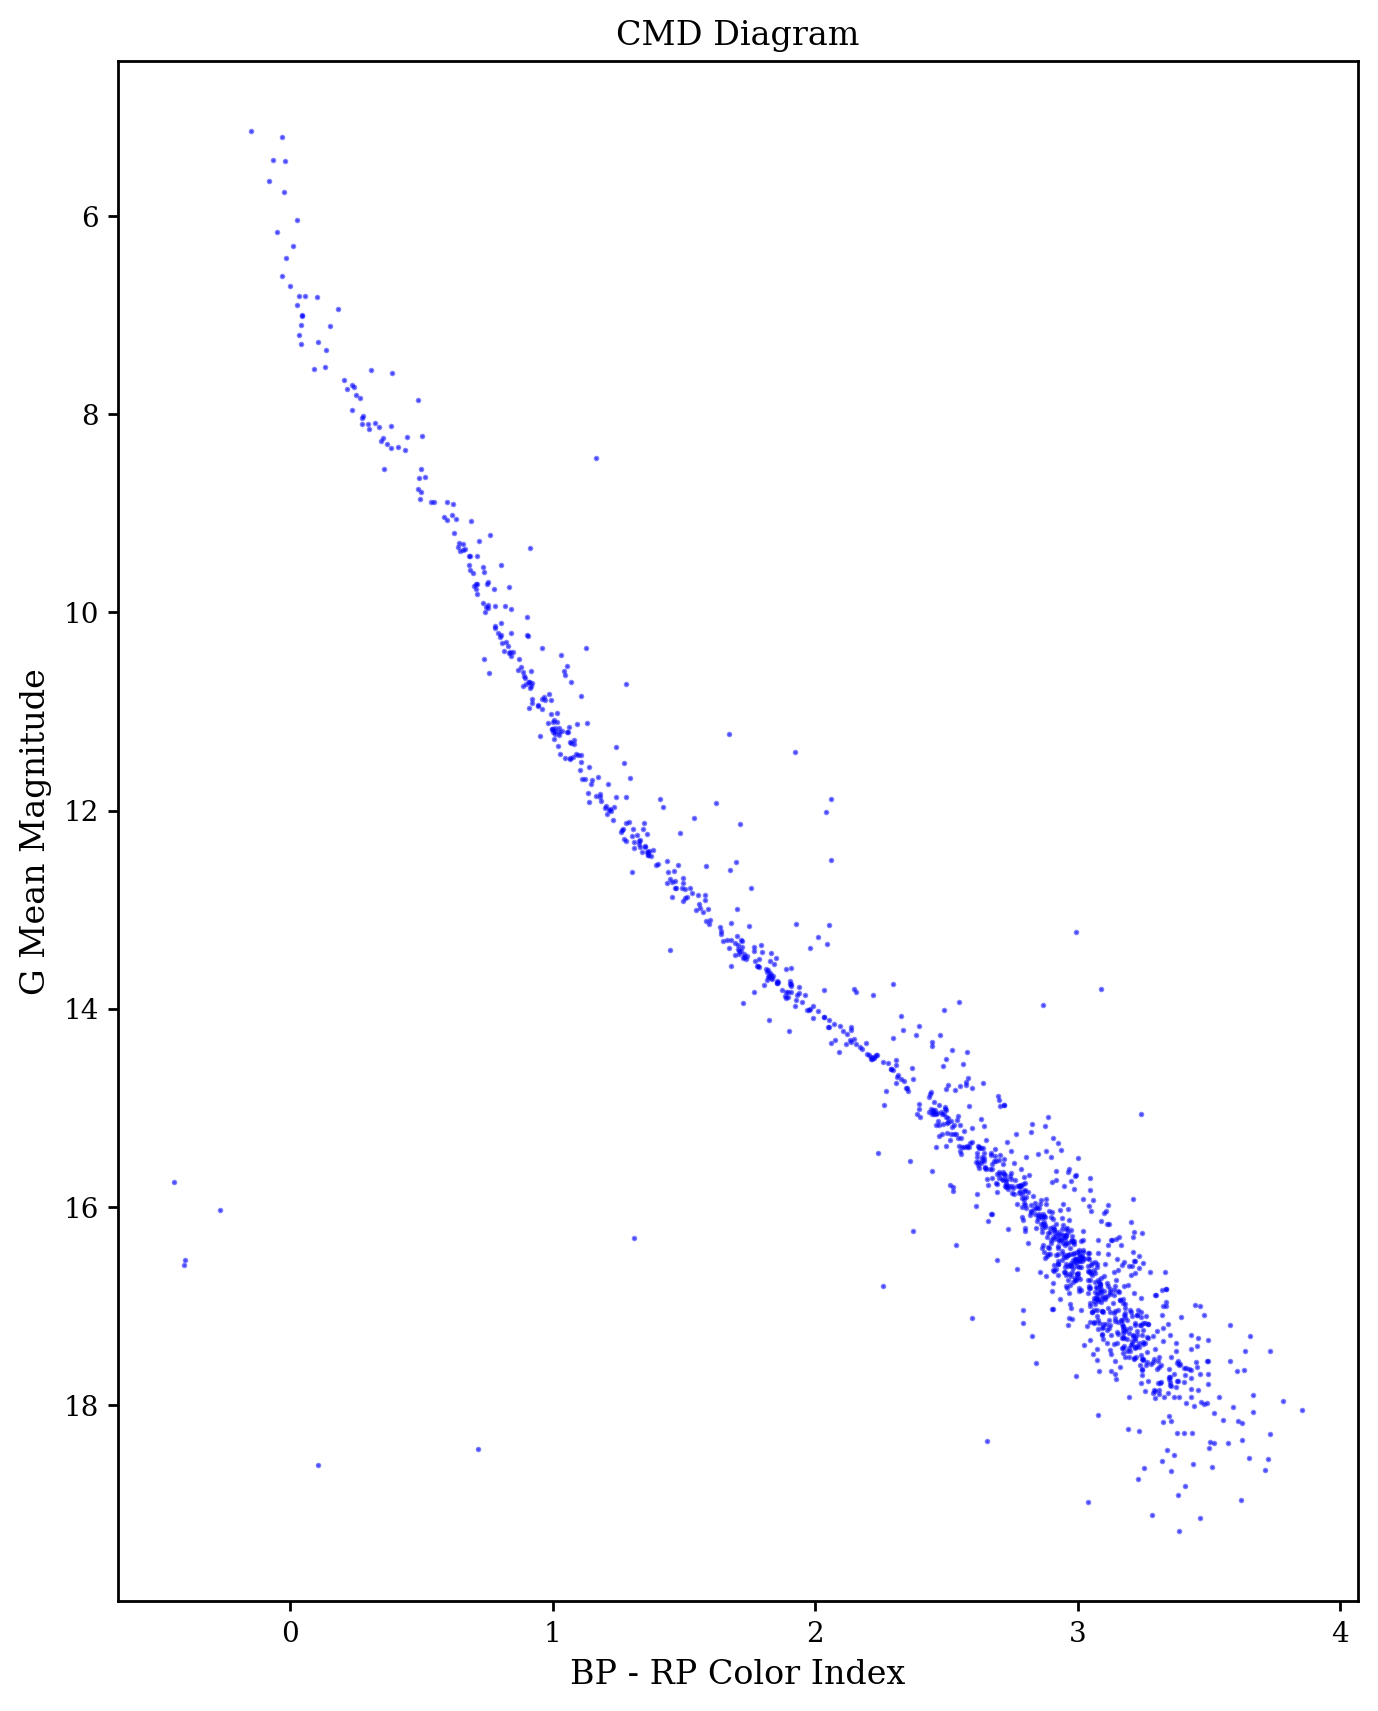

(<Figure size 800x1000 with 1 Axes>,
 <Axes: title={'center': 'CMD Diagram'}, xlabel='BP - RP Color Index', ylabel='G Mean Magnitude'>)

In [4]:
gaia_analyzer.plot_hr_diagram(show=True)

In [5]:
fitter = MISTFitter(data=df, age_range=(70e6, 160e6))

In [6]:
sampler = fitter.sample_cluster(n_walkers=32, n_burn=200, n_steps=2000)

100%|██████████| 2000/2000 [06:23<00:00,  5.21it/s]


Median cluster parameters:
Age=1.21e+08 yr, [Fe/H]=0.26, Distance=125.3 pc, A_V=0.12


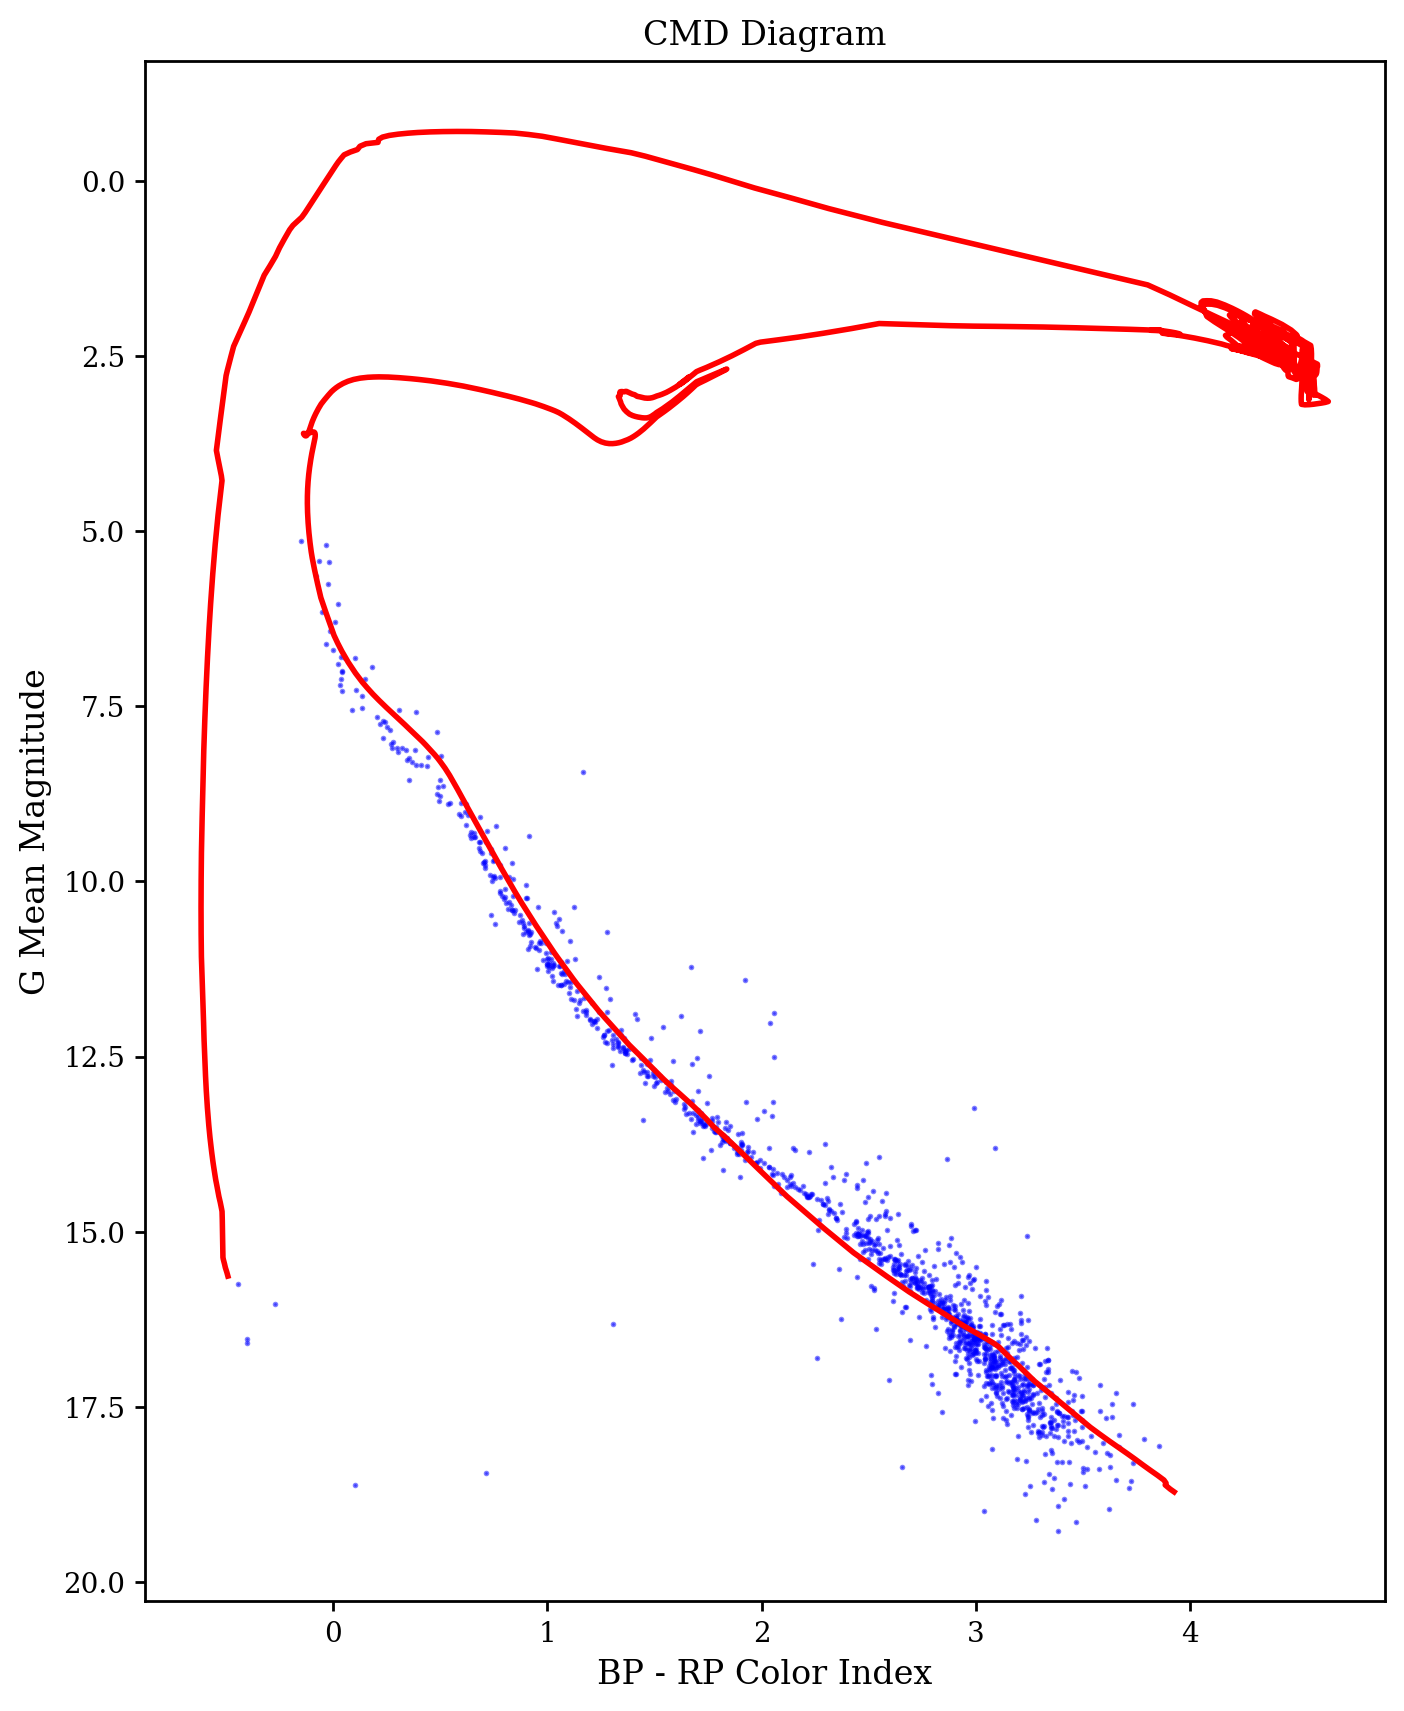

(<Figure size 800x1000 with 1 Axes>,
 <Axes: title={'center': 'CMD Diagram'}, xlabel='BP - RP Color Index', ylabel='G Mean Magnitude'>)

In [7]:
# Step 3: Inspect posterior
samples = fitter.get_samples()
median_params = fitter.get_median_model()
print(f"Median cluster parameters:\nAge={median_params[0]:.2e} yr, [Fe/H]={median_params[1]:.2f}, "
      f"Distance={median_params[2]:.1f} pc, A_V={median_params[3]:.2f}")

# Step 4: Plot median
fitter.plot_isochrone(median_params)

Best cluster parameters:
Age=1.21e+08 yr, [Fe/H]=0.26, Distance=125.3 pc, A_V=0.12


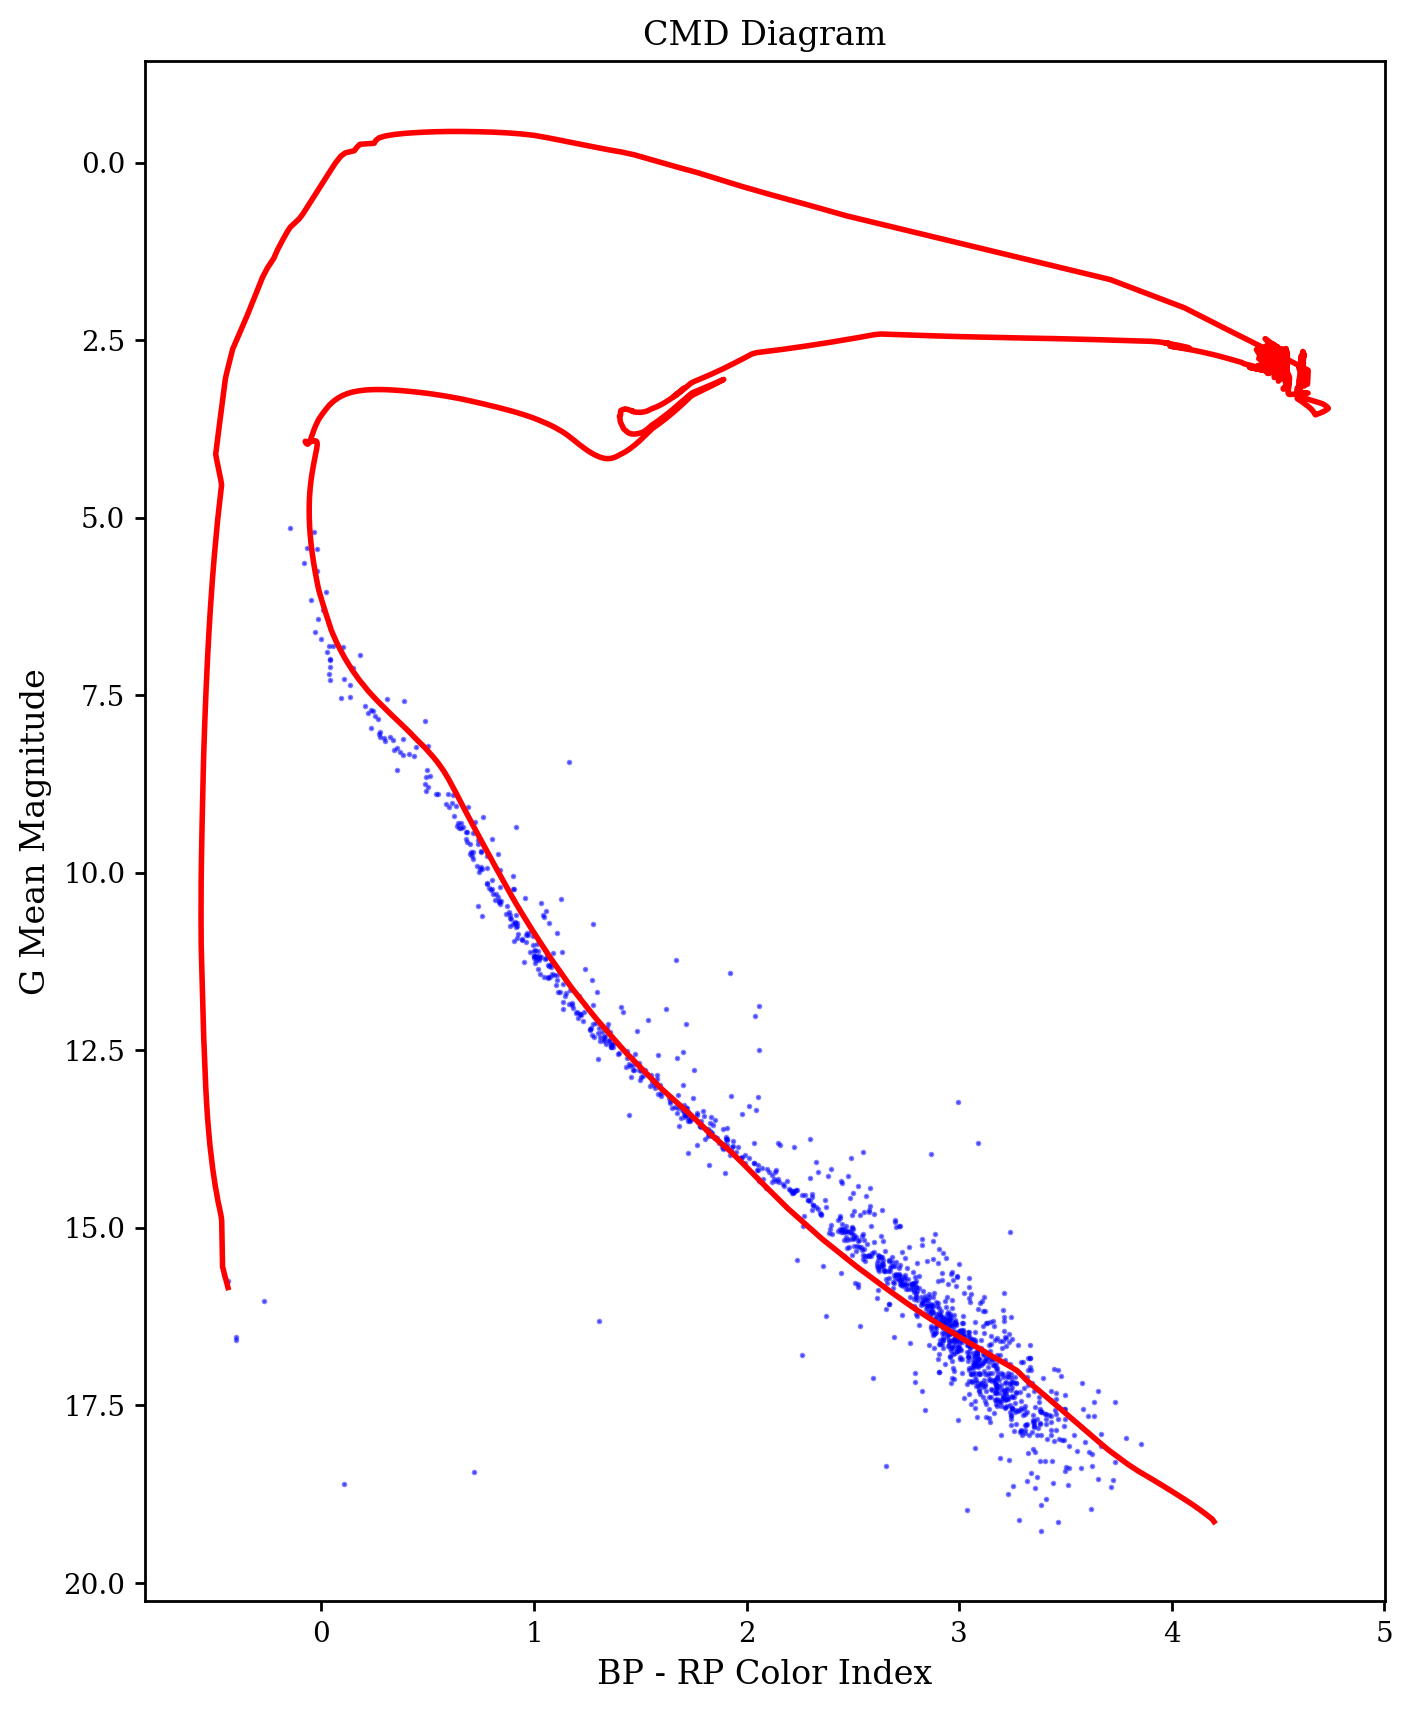

(<Figure size 800x1000 with 1 Axes>,
 <Axes: title={'center': 'CMD Diagram'}, xlabel='BP - RP Color Index', ylabel='G Mean Magnitude'>)

In [8]:
# Step 5: plot best model
best_params = fitter.get_best_model()
print(f"Best cluster parameters:\nAge={median_params[0]:.2e} yr, [Fe/H]={median_params[1]:.2f}, "
      f"Distance={median_params[2]:.1f} pc, A_V={median_params[3]:.2f}")

# Step 4: Plot median
fitter.plot_isochrone(best_params)

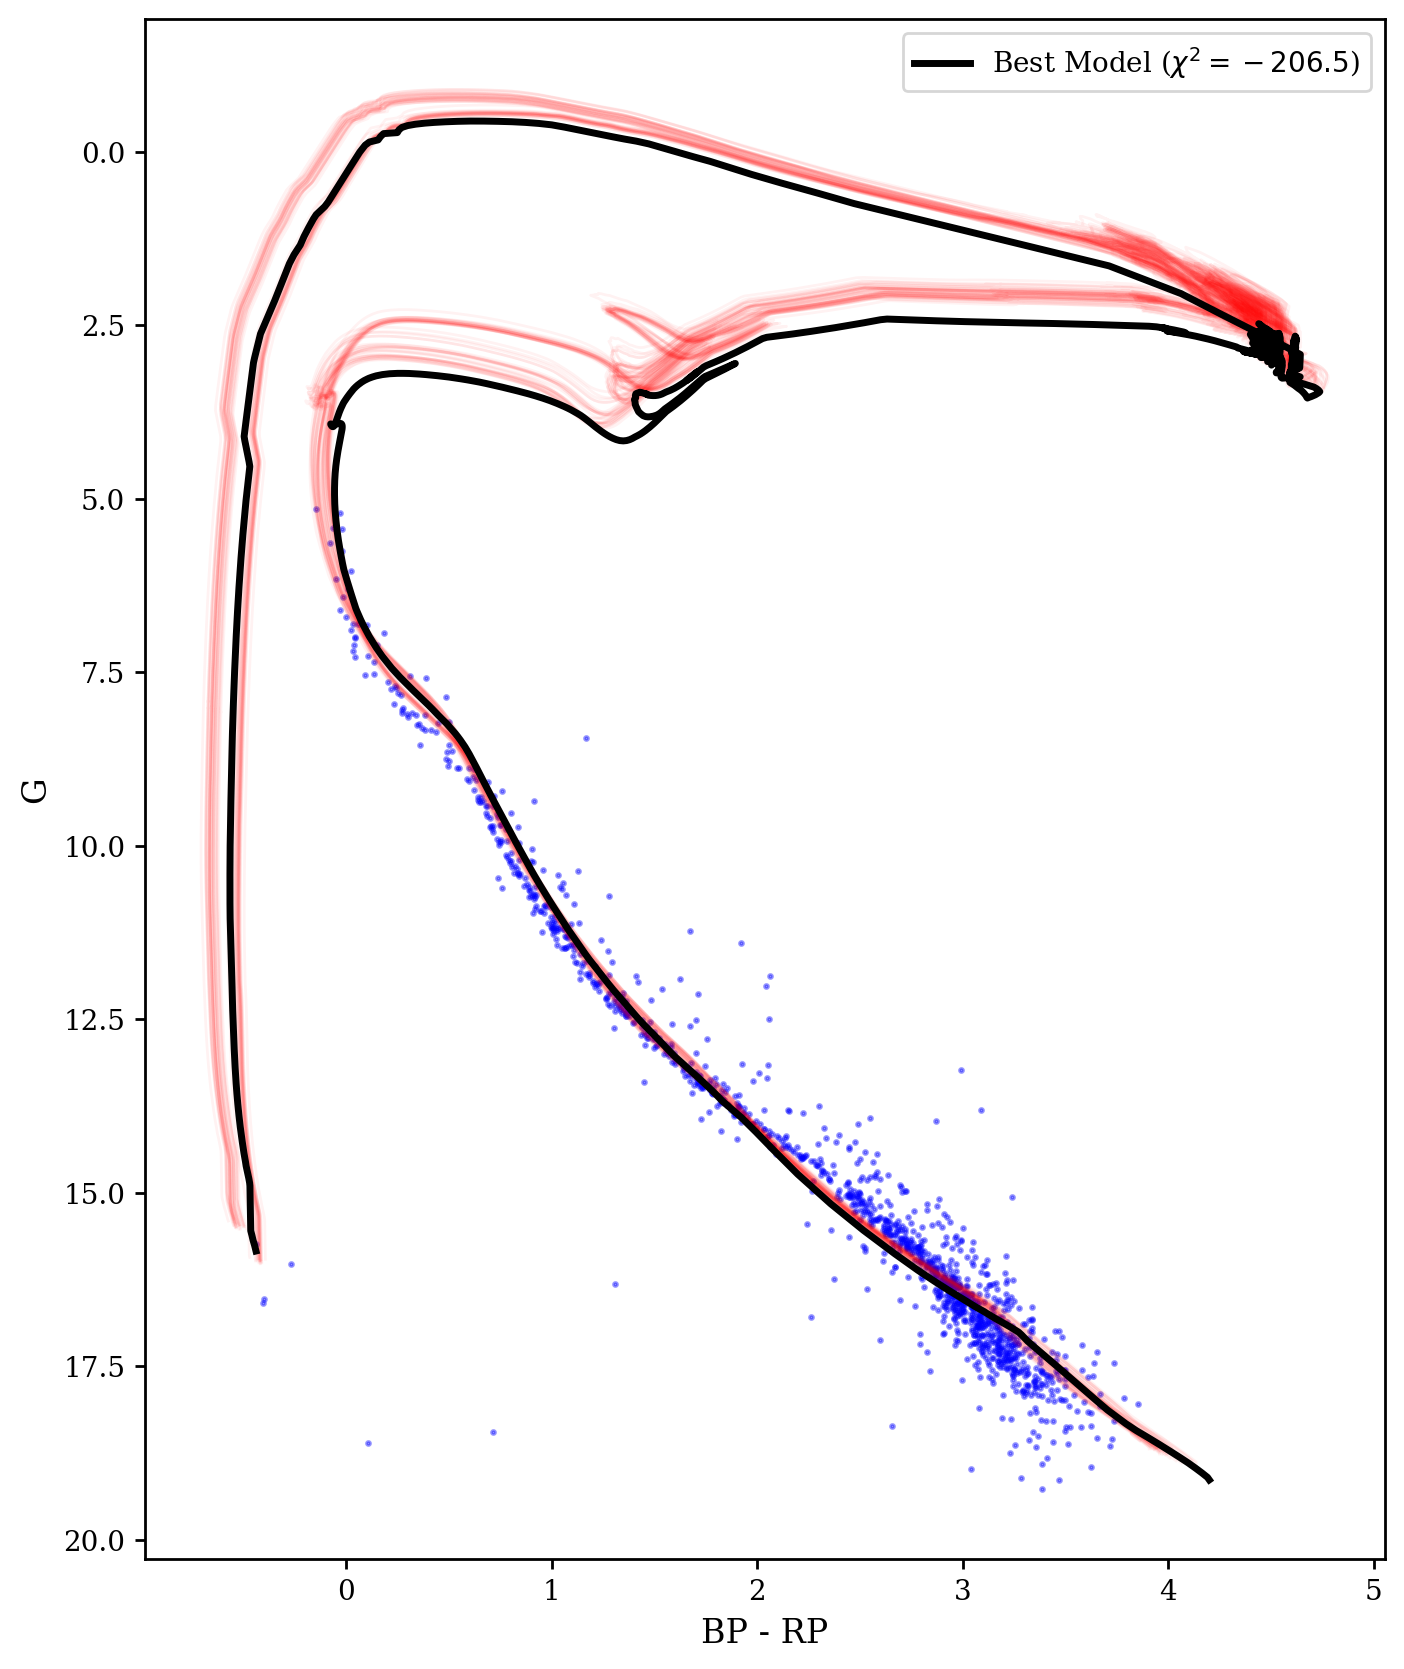

(<Figure size 800x1000 with 1 Axes>, <Axes: xlabel='BP - RP', ylabel='G'>)

In [9]:
fitter.plot_good_isochrones(chi2_cutoff=1)

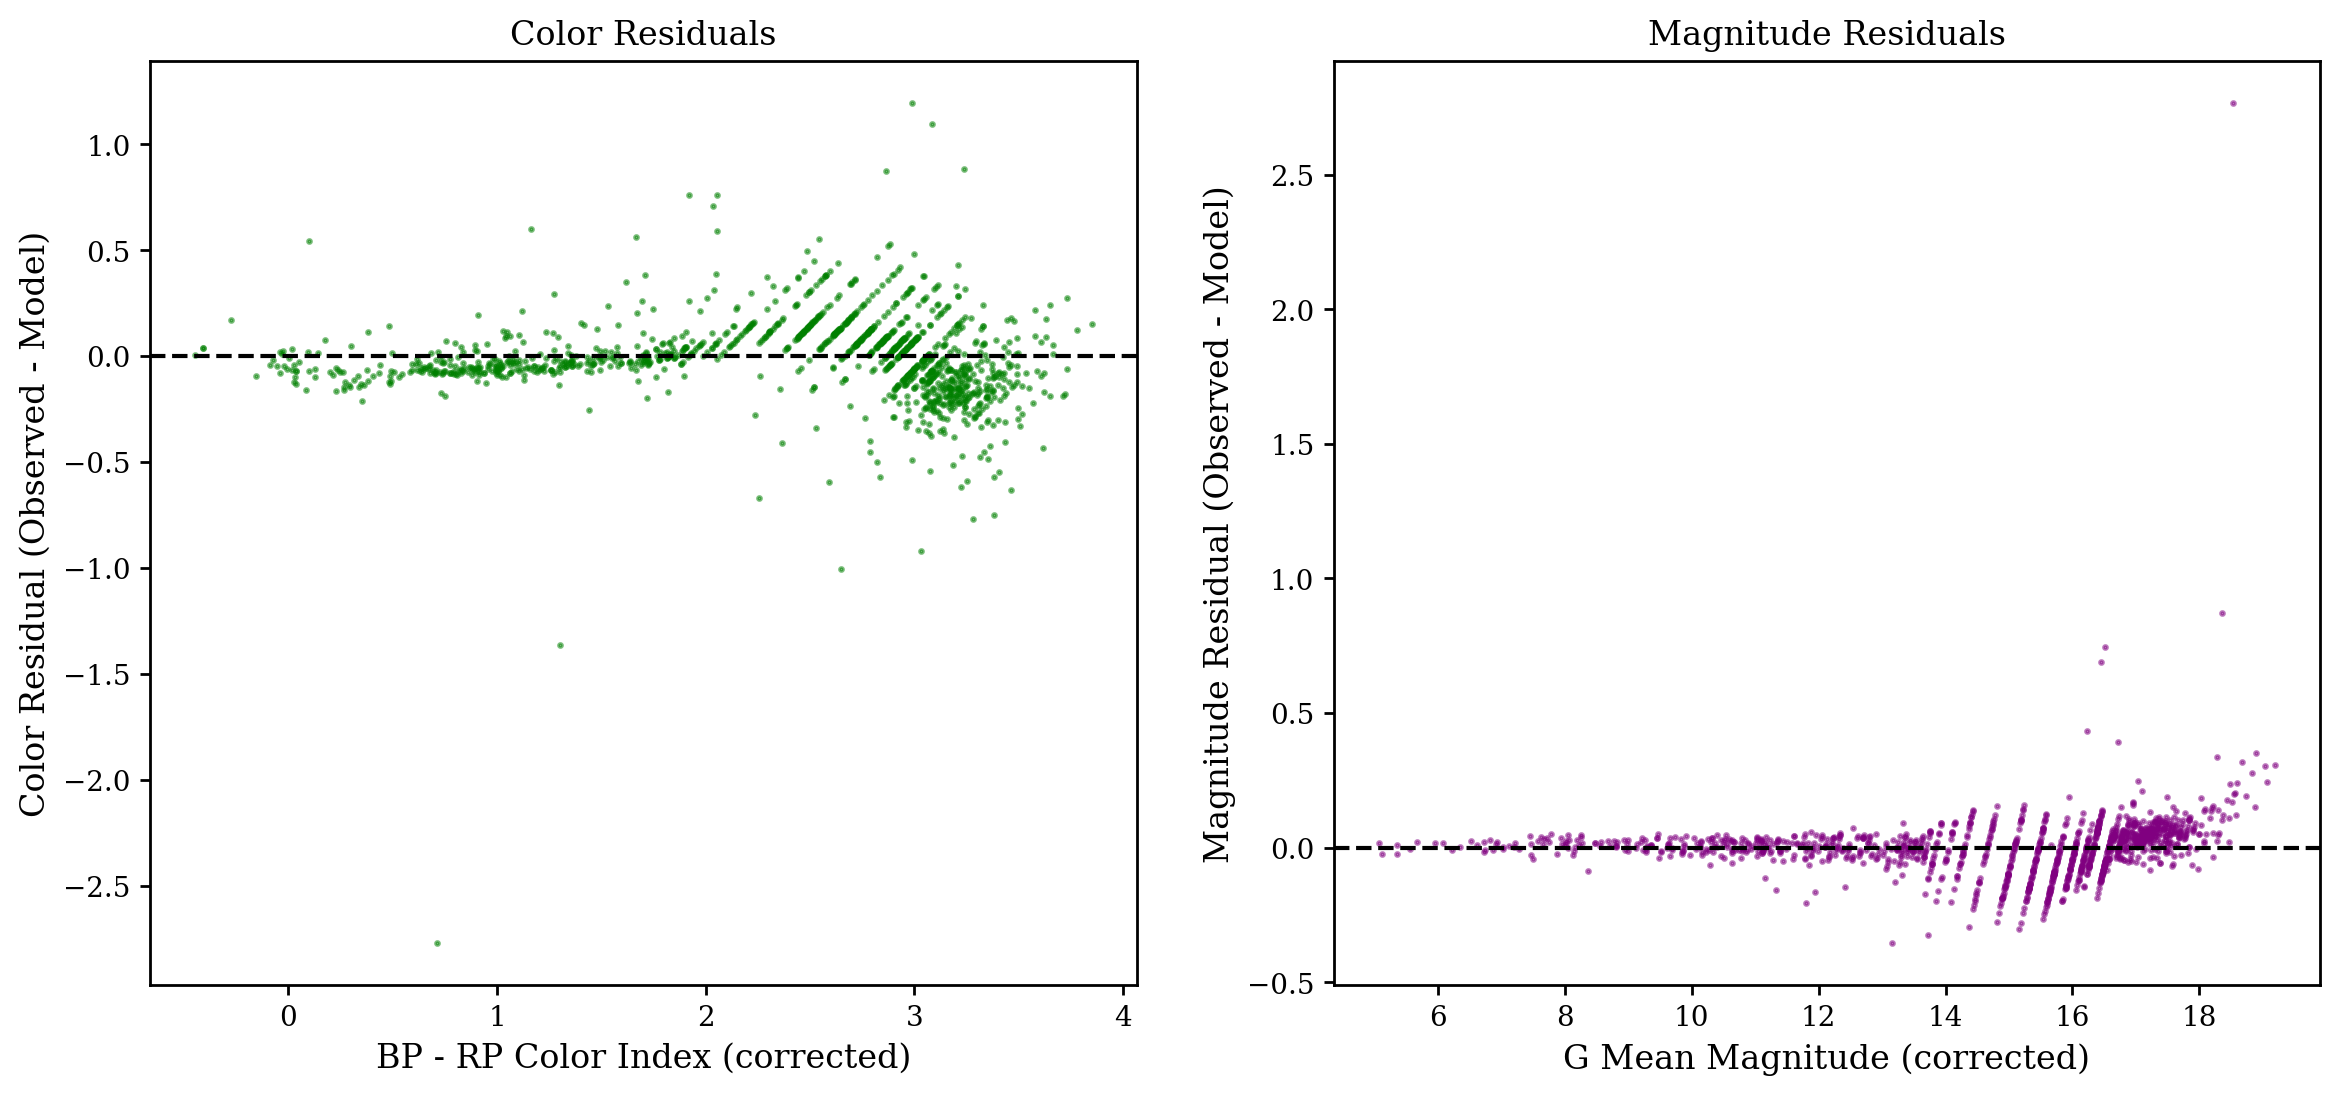

(<Figure size 1400x600 with 2 Axes>,
 (<Axes: title={'center': 'Color Residuals'}, xlabel='BP - RP Color Index (corrected)', ylabel='Color Residual (Observed - Model)'>,
  <Axes: title={'center': 'Magnitude Residuals'}, xlabel='G Mean Magnitude (corrected)', ylabel='Magnitude Residual (Observed - Model)'>))

In [10]:
fitter.plot_residuals(theta=fitter.get_best_model())

2025-11-12 17:35:24,254 - WARNING - Too few points to create valid contours
2025-11-12 17:35:24,307 - WARNING - Too few points to create valid contours
2025-11-12 17:35:24,324 - WARNING - Too few points to create valid contours
2025-11-12 17:35:24,348 - WARNING - Too few points to create valid contours
2025-11-12 17:35:24,372 - WARNING - Too few points to create valid contours


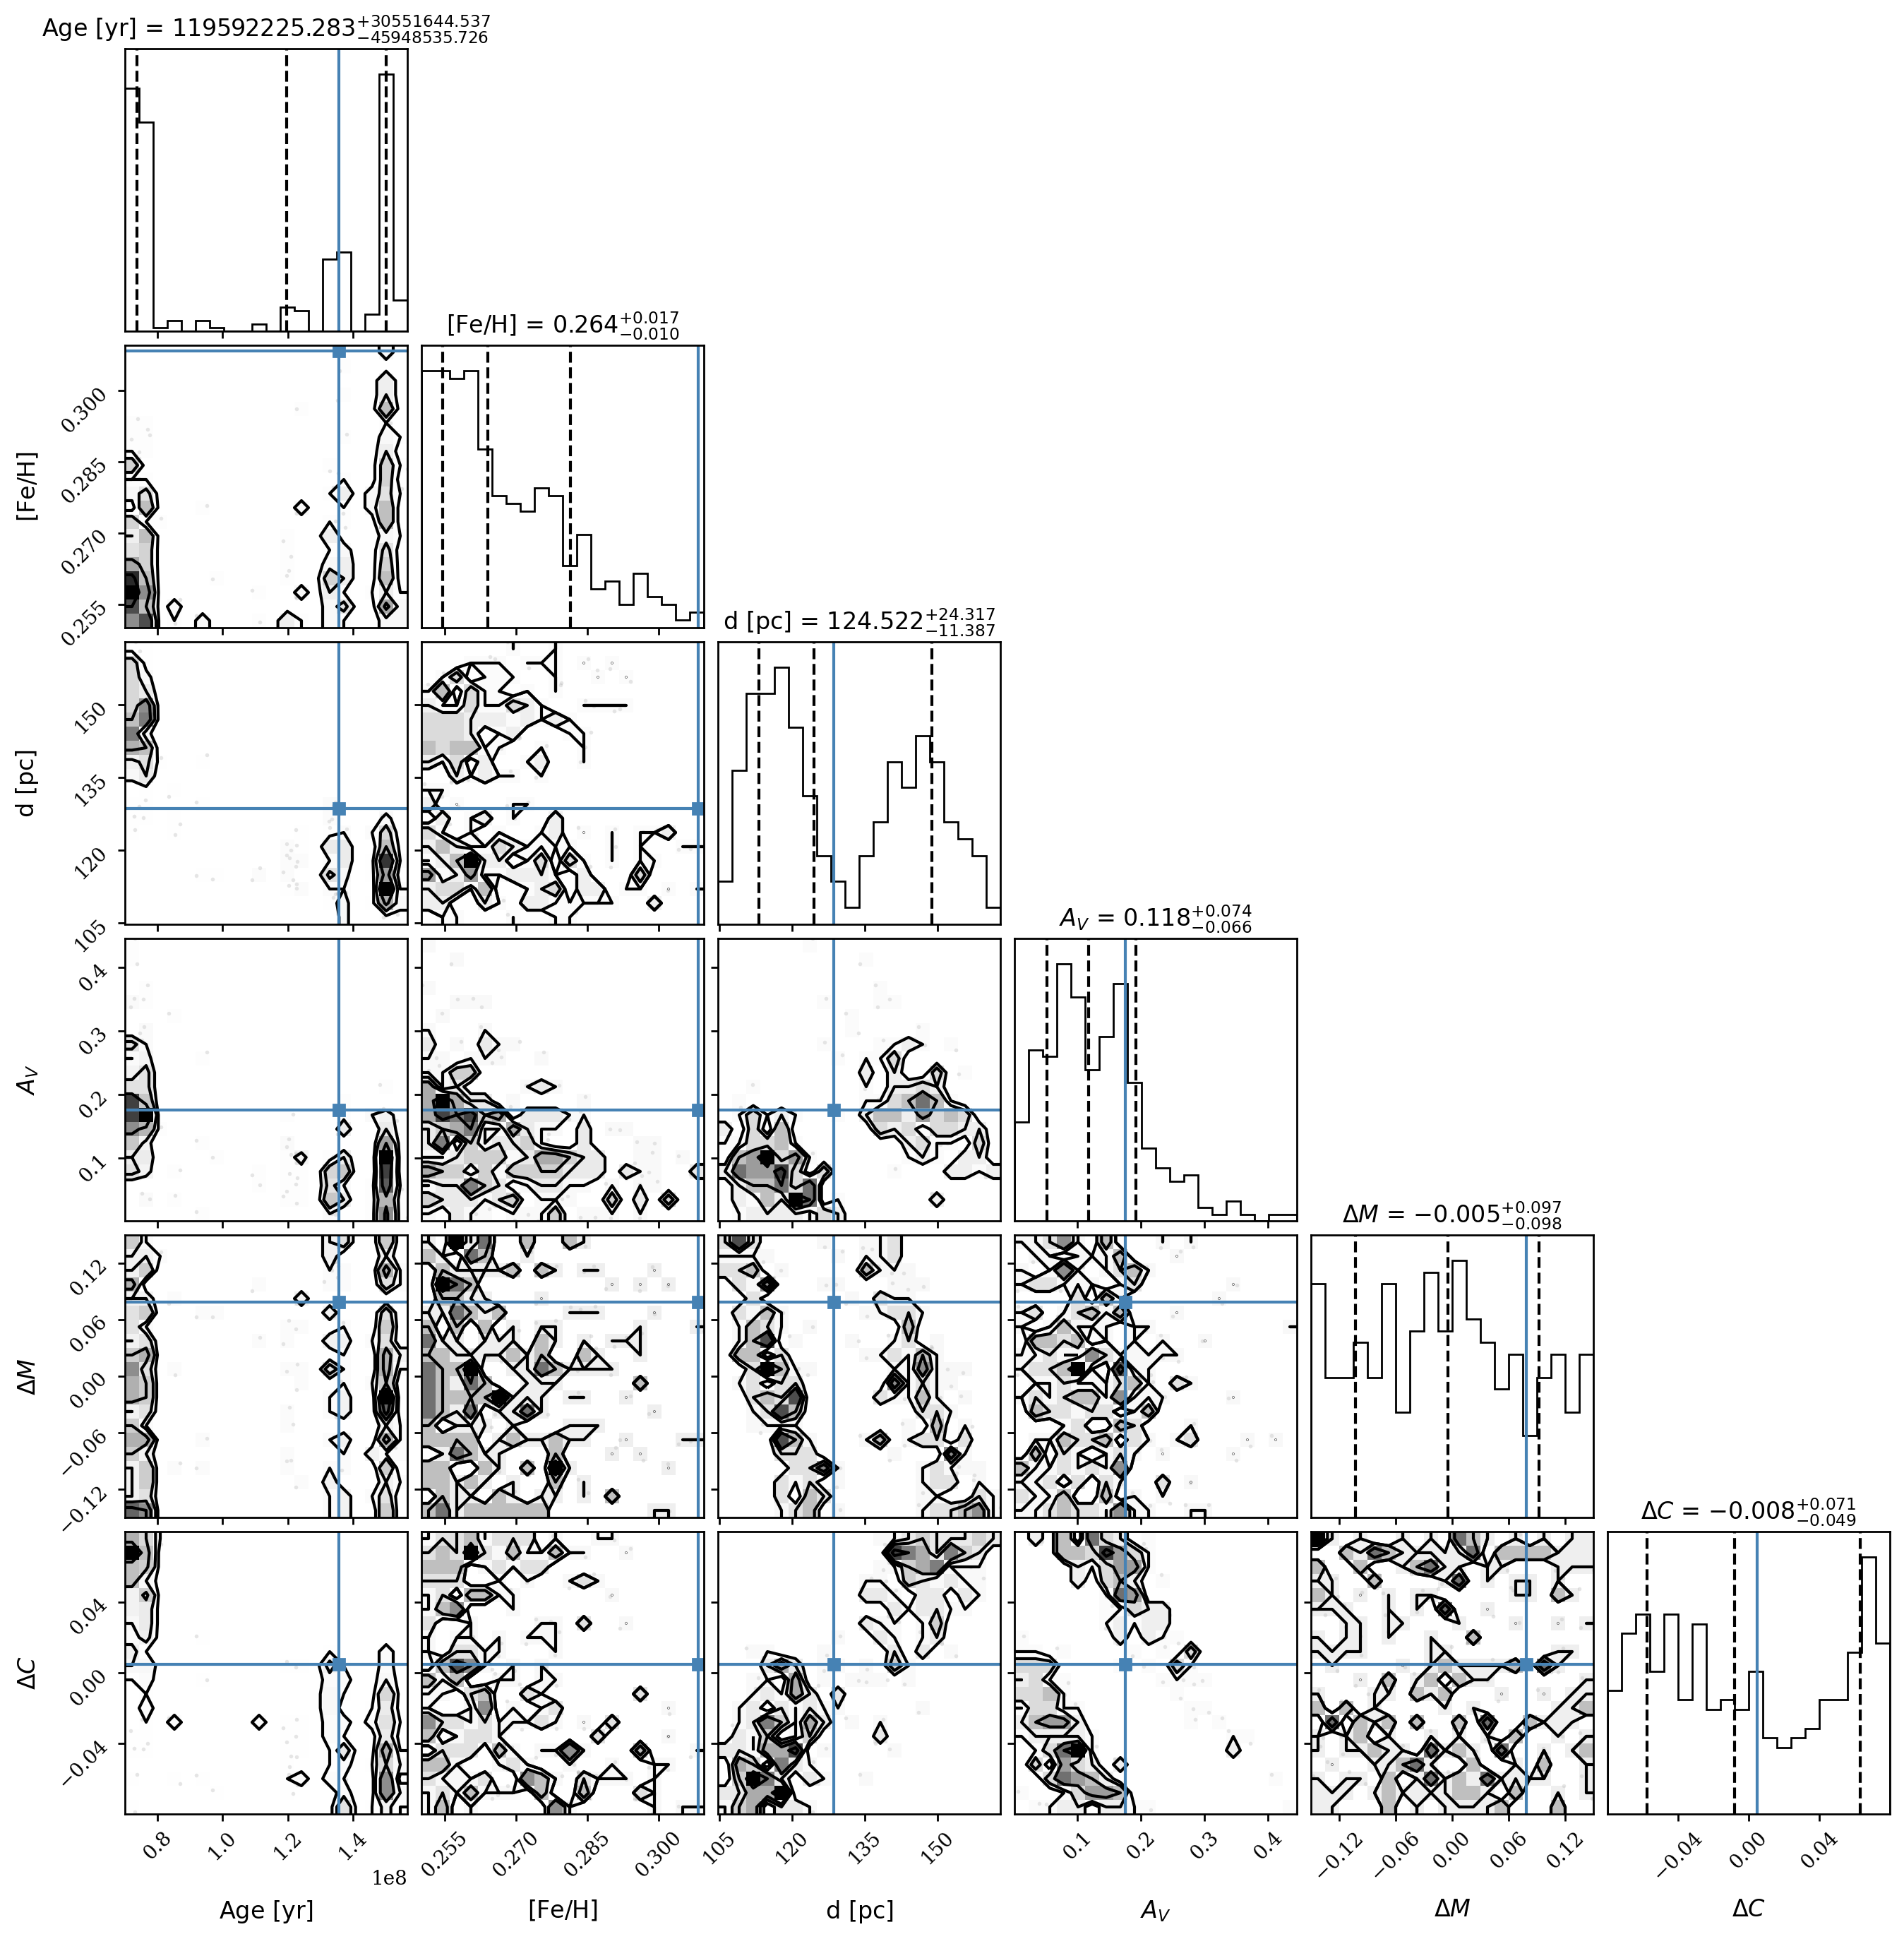

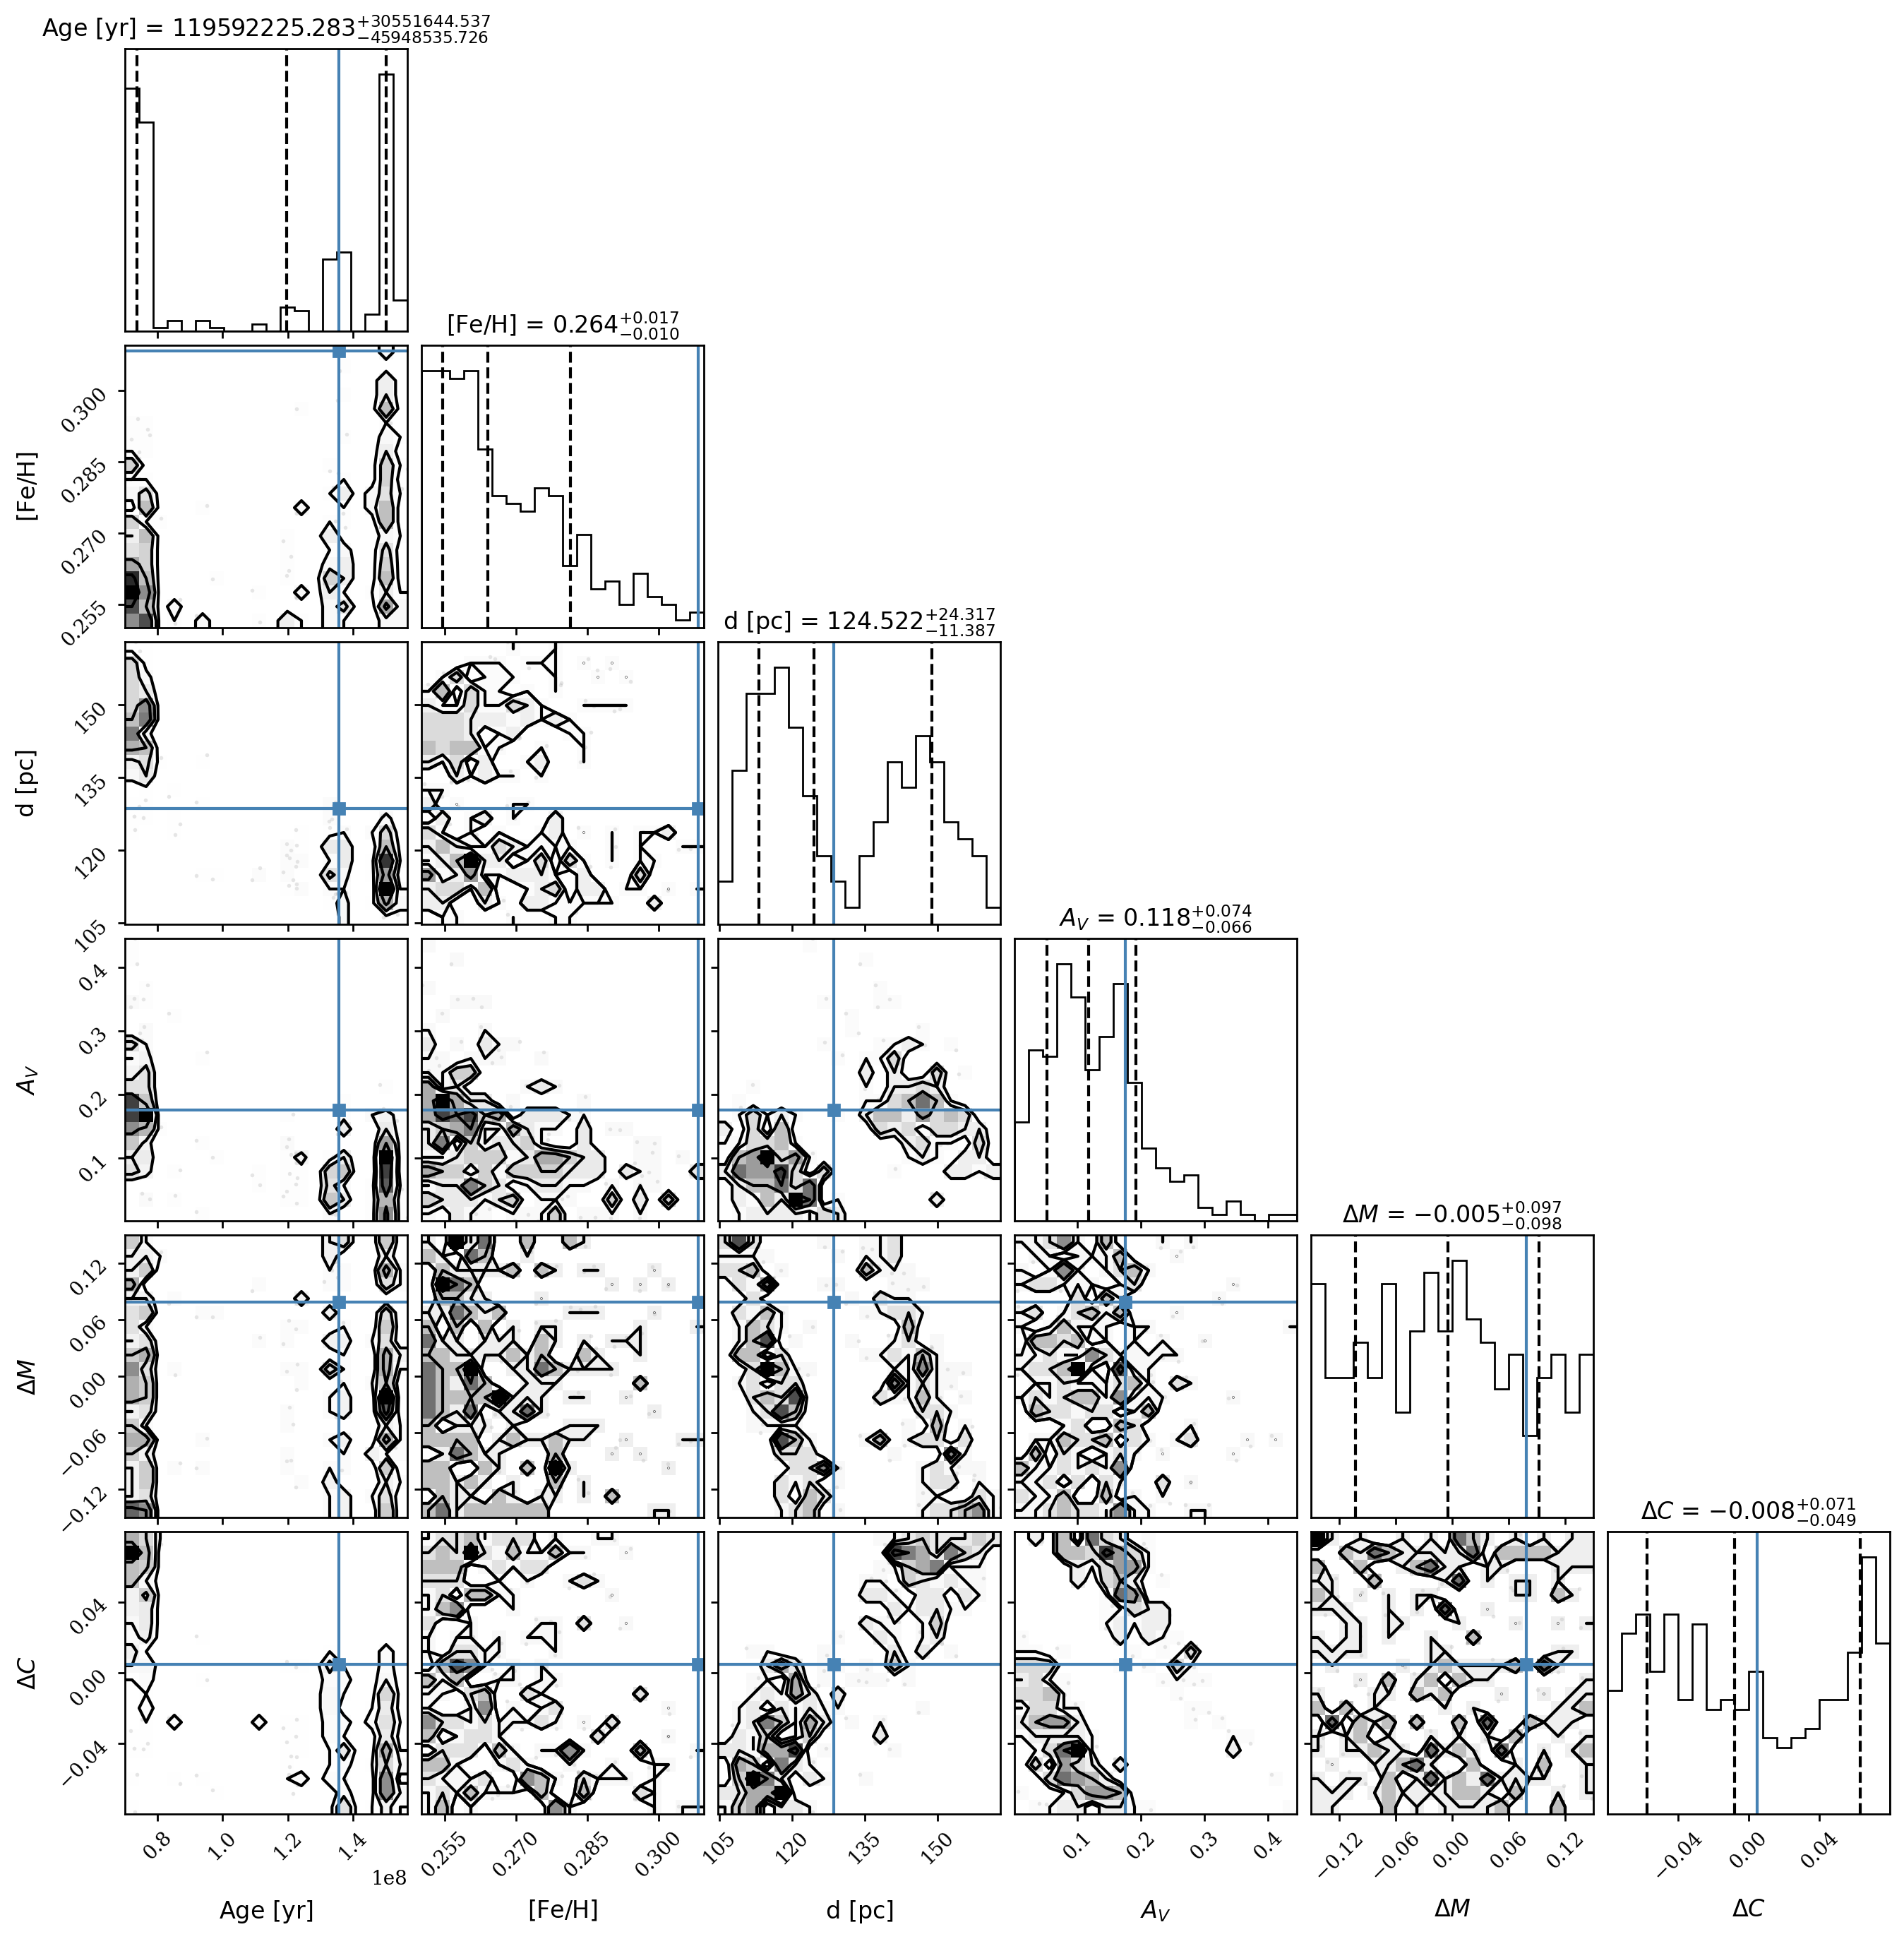

In [11]:
fitter.plot_corner(sampler, discard=200, thin=200)

/var/folders/12/zdvhzg650g17gbnt14_55w_m0000gn/T/ipykernel_72641/3925245560.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  isochrone_df = pd.read_csv('mist_isochrone_140Myr.dat', delim_whitespace=True, comment='#')


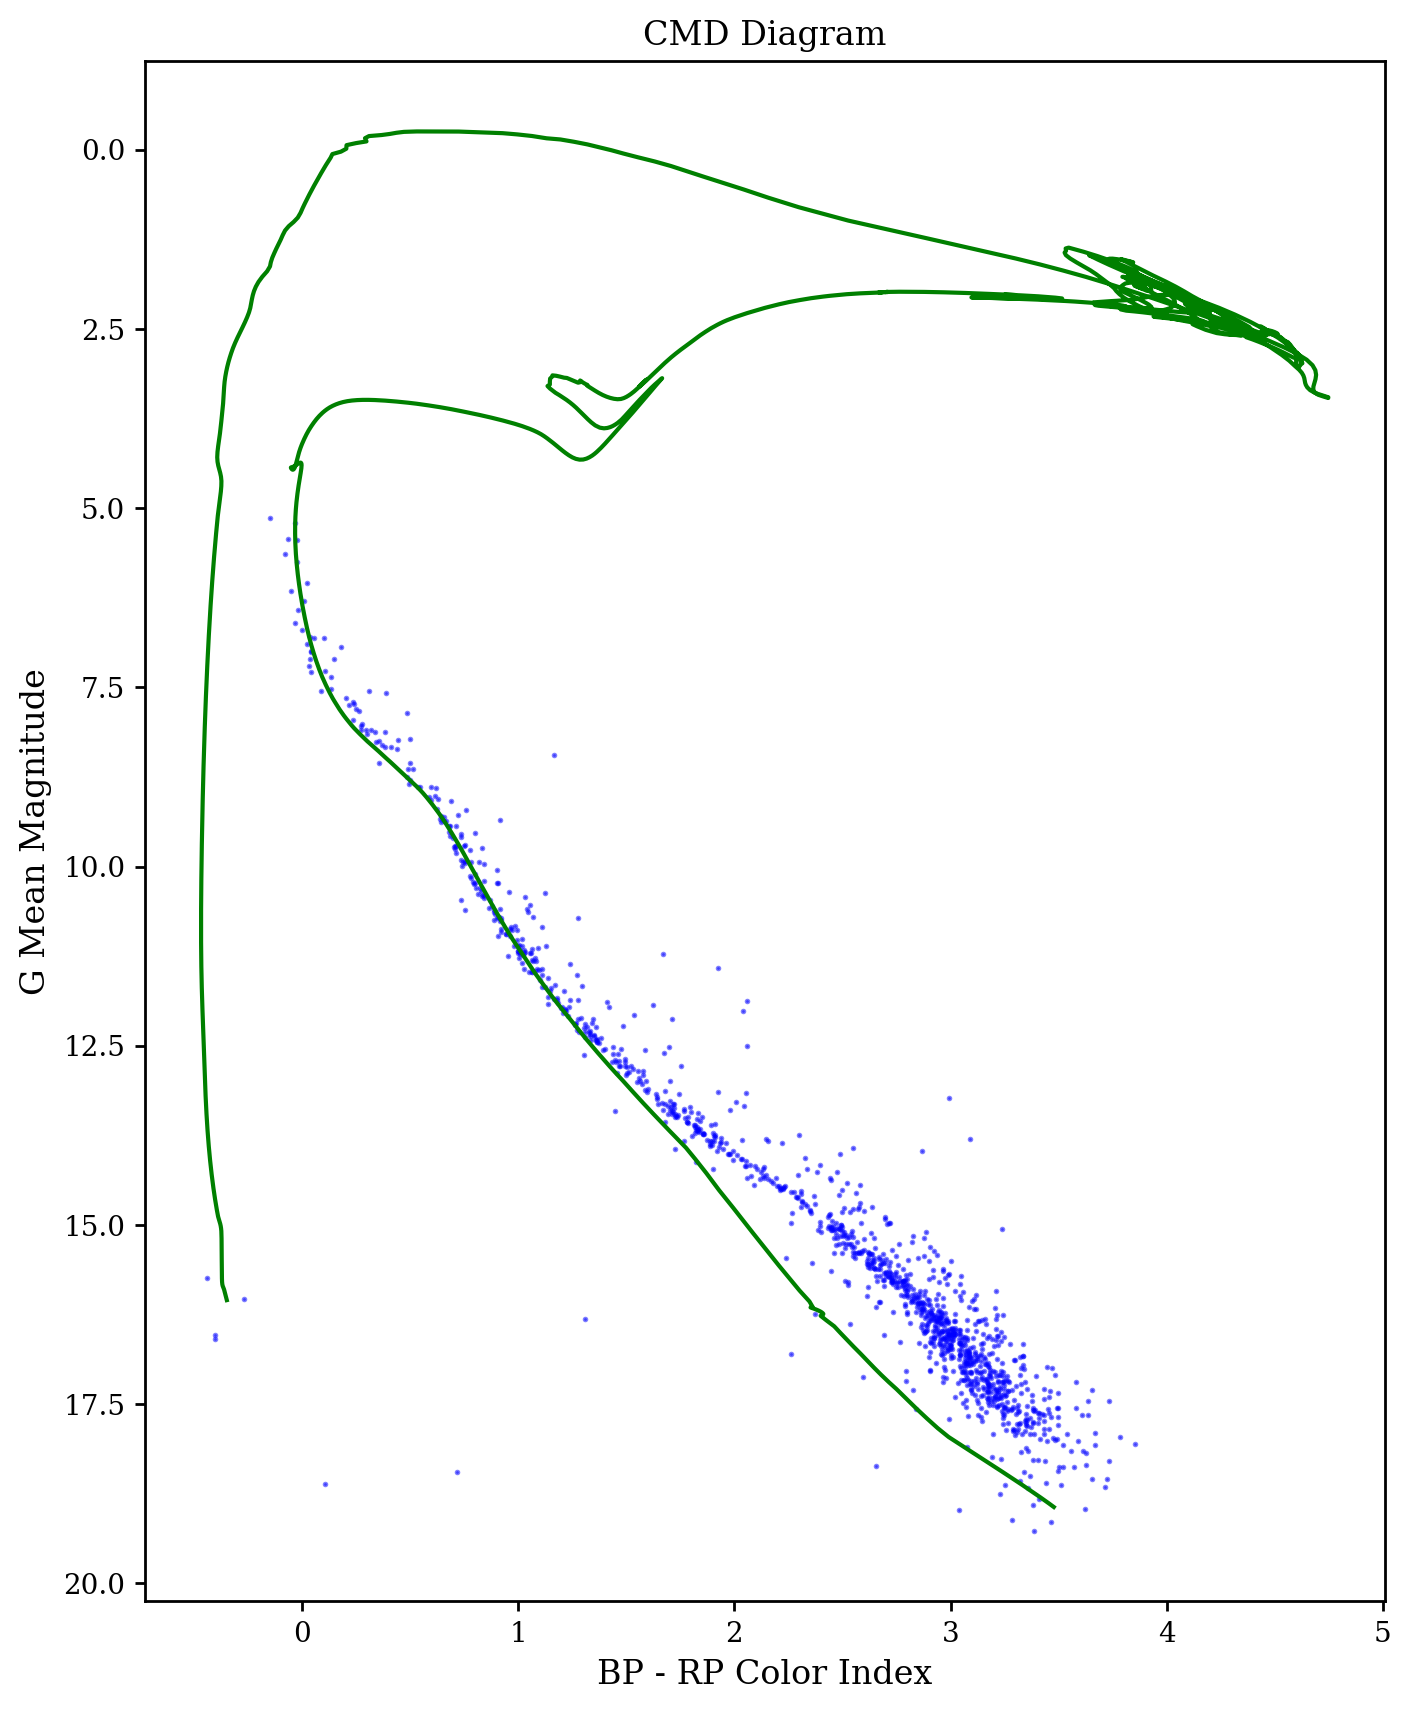

In [ ]:
# Testing using actual isochrone
import pandas as pd

isochrone_df = pd.read_csv('data/mist_isochrone_140Myr.dat', delim_whitespace=True, comment='#')
fig, ax = gaia_analyzer.plot_hr_diagram(show=False)

isochrone_df['color'] = isochrone_df['Gaia_BP_EDR3'] - isochrone_df['Gaia_RP_EDR3'] + 0.15
isochrone_df['magnitude'] = isochrone_df['Gaia_G_EDR3'] + 6

ax.plot(isochrone_df['color'], isochrone_df['magnitude'], color='green', label='Isochrone')
plt.show()

In [13]:
from analyzer import BinaryMixtureFitter

binary_fitter = BinaryMixtureFitter(data=df)
binary_fitter.fit(theta=fitter.get_best_model())

print(binary_fitter.get_mixture_weights())

2025-11-12 17:35:25,462 - INFO - Starting EM fit
2025-11-12 17:35:25,462 - INFO - Initial weights: [0.8 0.2 0. ]
  0%|          | 0/40 [00:00<?, ?it/s]2025-11-12 17:35:27,989 - INFO - lnL stats | single: mean=-1.06 max=0.32, binary: mean=-0.69 max=0.20, field: mean=0.00 max=0.00
2025-11-12 17:35:27,990 - INFO - Updated mixture weights: [6.85328474e-01 3.14281966e-01 3.89559797e-04]
  2%|▎         | 1/40 [00:02<01:38,  2.53s/it]2025-11-12 17:35:27,994 - INFO - lnL stats | single: mean=-1.06 max=0.32, binary: mean=-0.69 max=0.20, field: mean=0.00 max=0.00
2025-11-12 17:35:27,995 - INFO - Updated mixture weights: [0.58952928 0.38965499 0.02081572]
2025-11-12 17:35:27,997 - INFO - lnL stats | single: mean=-1.06 max=0.32, binary: mean=-0.69 max=0.20, field: mean=0.00 max=0.00
2025-11-12 17:35:27,998 - INFO - Updated mixture weights: [0.49355752 0.40363174 0.10281073]
2025-11-12 17:35:28,001 - INFO - lnL stats | single: mean=-1.06 max=0.32, binary: mean=-0.69 max=0.20, field: mean=0.00 max=0

[0.23613664 0.25654346 0.50731989]


In [14]:
from downloader import LightCurveExtractor

lightcurve_analyzer = LightCurveExtractor(download_dir='lightcurves/')

ids = gaia_analyzer.extract_source_ids()[:10]
lightcurves = lightcurve_analyzer.extract_gaia_lightcurves(ids)

2025-11-12 17:35:28,160 - INFO - Set Lightkurve download directory to lightcurves/
  0%|          | 0/10 [00:00<?, ?it/s]2025-11-12 17:36:19,675 - INFO - Querying source_id 3763976194792448 -> tess_id 377056867
2% (366/17305) of the cadences will be ignored due to the quality mask (quality_bitmask=17087).
2025-11-12 17:38:02,729 - INFO - 2% (366/17305) of the cadences will be ignored due to the quality mask (quality_bitmask=17087).
3% (605/17888) of the cadences will be ignored due to the quality mask (quality_bitmask=17087).
2025-11-12 17:38:02,778 - INFO - 3% (605/17888) of the cadences will be ignored due to the quality mask (quality_bitmask=17087).
 10%|█         | 1/10 [01:43<15:28, 103.18s/it]2025-11-12 17:38:02,857 - INFO - Querying source_id 11352324413414016 -> tess_id 416678539
2% (362/17305) of the cadences will be ignored due to the quality mask (quality_bitmask=17087).
2025-11-12 17:46:51,460 - INFO - 2% (362/17305) of the cadences will be ignored due to the quality mask (

In [15]:
lightcurves

{'3763976194792448': (array([2144.52023964, 2144.52162857, 2144.52301751, ..., 3233.12087543,
         3233.12226437, 3233.1236533 ]),
  MaskedNDArray([1.00048361, 0.9991832 , 0.99980555, ..., 0.99983209,
                 1.00051054, 0.99981253]),
  <TessLightCurve length=31801 LABEL="TIC 377056867" SECTOR=70 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
         time             flux      ...   pos_corr1      pos_corr2   
                                    ...      pix            pix      
         Time           float64     ...    float32        float32    
  ------------------ -------------- ... -------------- --------------
  2144.5202396418713  1.0004836e+00 ... -4.5235036e-03  2.4905917e-01
   2144.521628573452  9.9918320e-01 ... -8.8000922e-03  2.4835119e-01
  2144.5230175050315  9.9980555e-01 ... -7.4580326e-03  2.5075856e-01
   2144.524406436611  1.0008408e+00 ... -7.3669213e-03  2.4925636e-01
   2144.525795368192  1.0030885e+00 ... -6.8456451e-03  2.4841966e-01
   2144.527184299773  

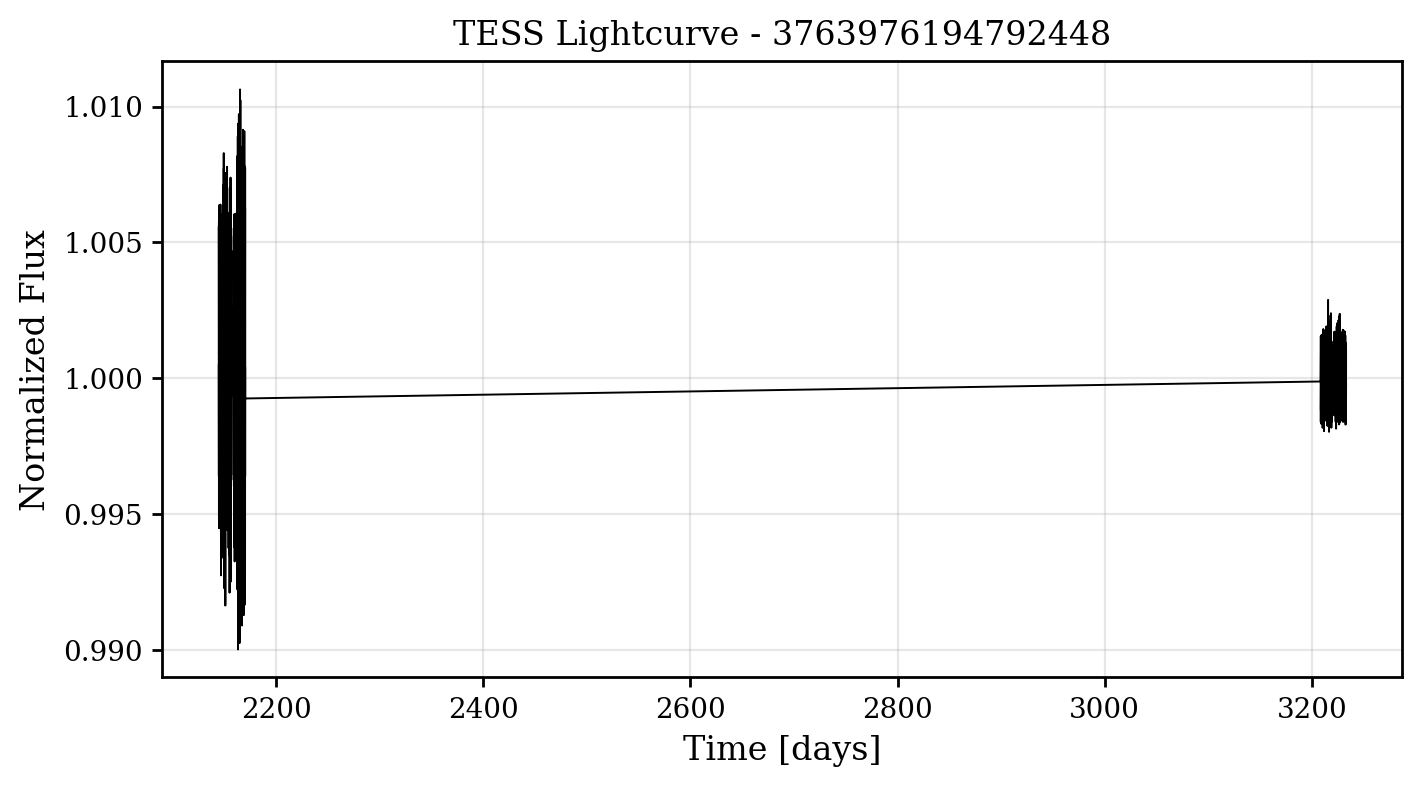

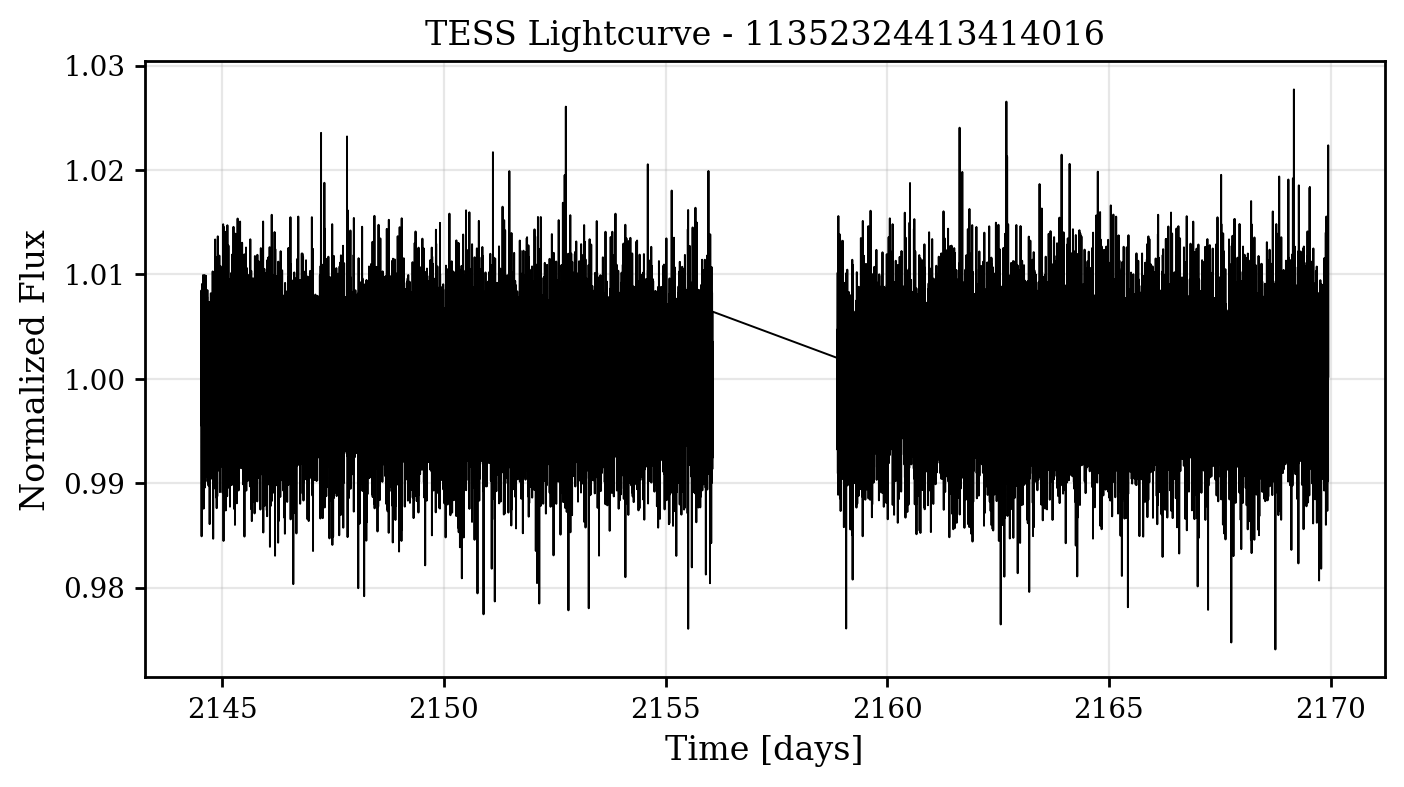

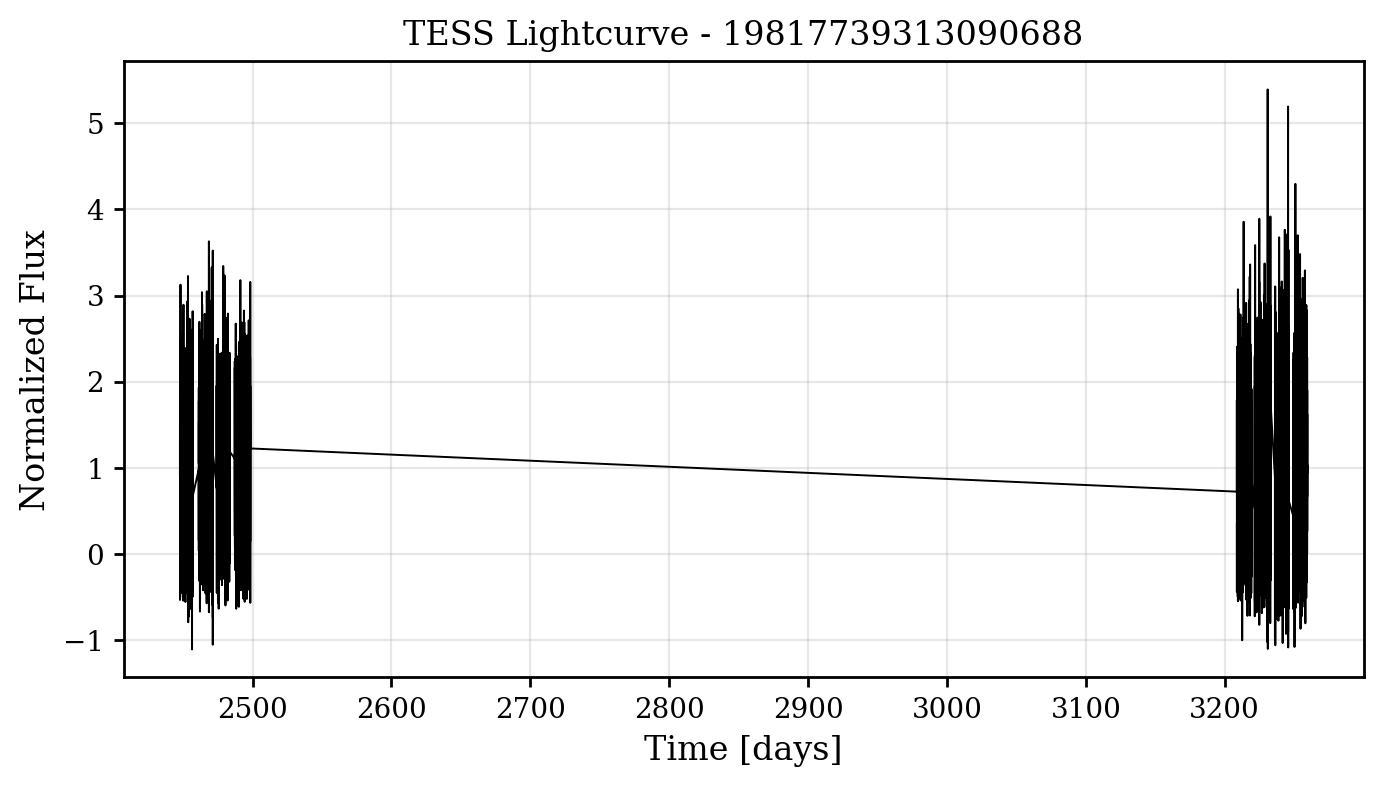

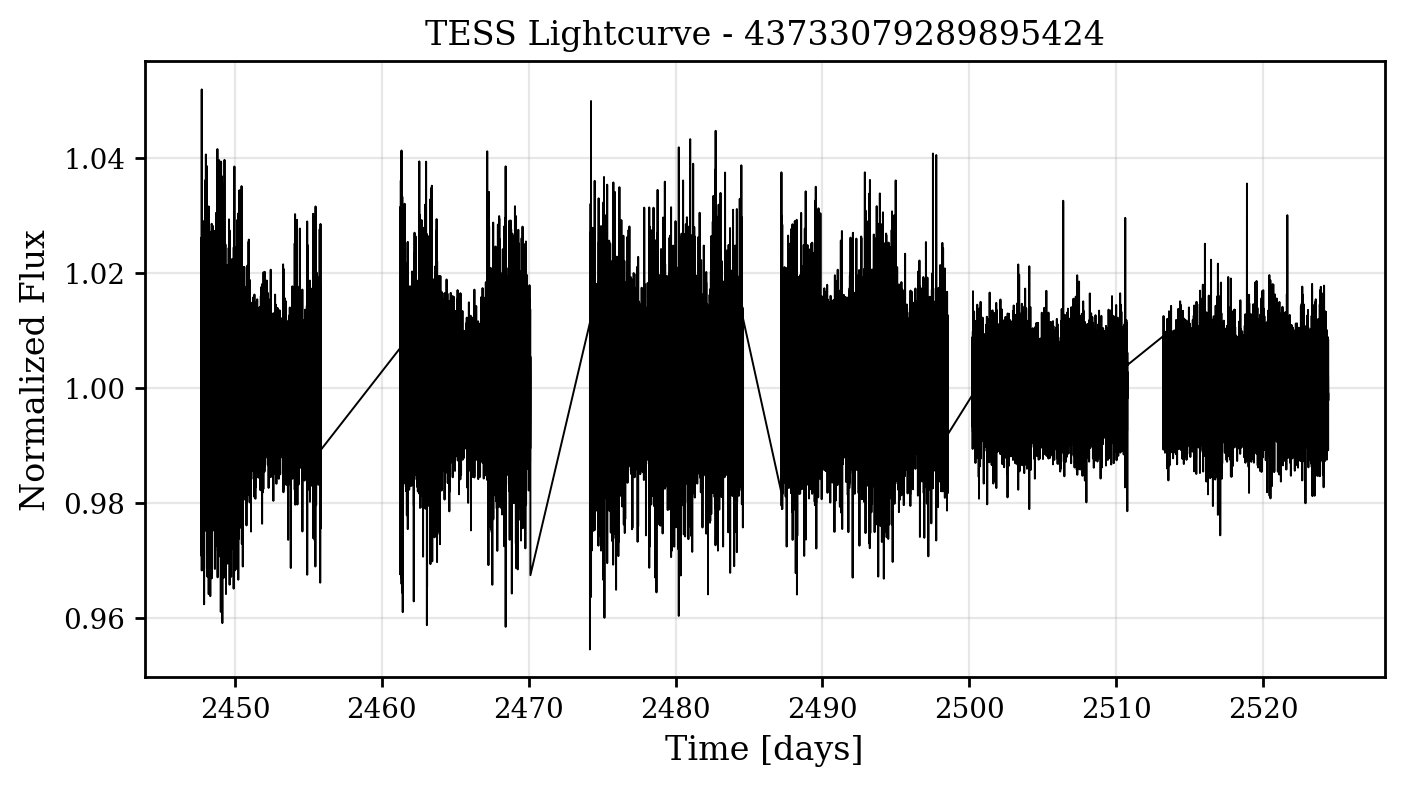

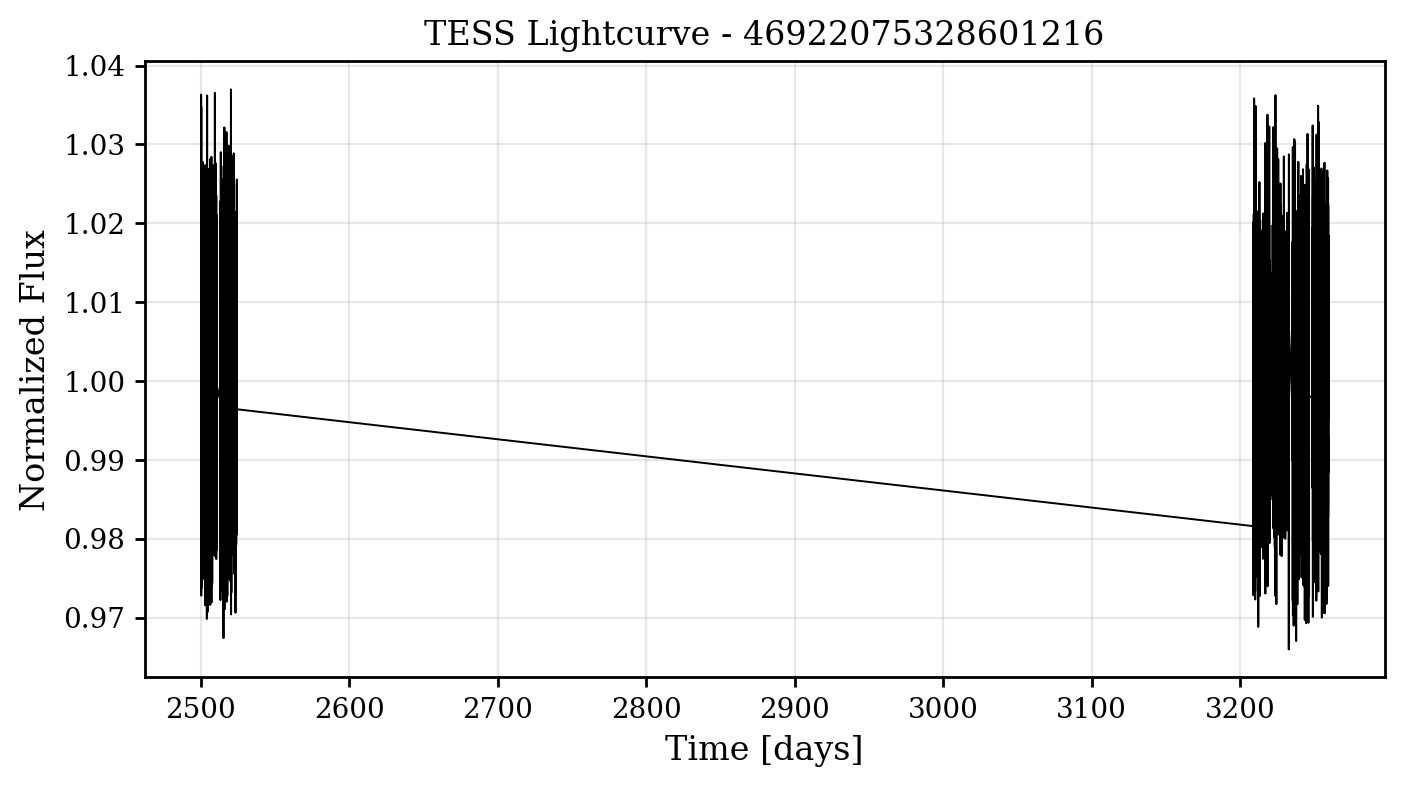

In [16]:
from analyzer import TESSAnalyzer

tess_analyzer = TESSAnalyzer(lightcurves=lightcurves)
tess_analyzer.batch_plot()

In [17]:
results = tess_analyzer.batch_analyze()
tess_analyzer.batch_plot_folded()

2025-11-12 17:58:53,208 - INFO - Analyzing lightcurve for 3763976194792448
2025-11-12 17:58:53,208 - ERROR - Analysis failed: unhashable type: 'numpy.ndarray'
2025-11-12 17:58:53,209 - INFO - Analyzing lightcurve for 11352324413414016
2025-11-12 17:58:53,209 - ERROR - Analysis failed: unhashable type: 'numpy.ndarray'
2025-11-12 17:58:53,209 - INFO - Analyzing lightcurve for 19817739313090688
2025-11-12 17:58:53,210 - ERROR - Analysis failed: unhashable type: 'numpy.ndarray'
2025-11-12 17:58:53,210 - INFO - Analyzing lightcurve for 43733079289895424
2025-11-12 17:58:53,210 - ERROR - Analysis failed: unhashable type: 'numpy.ndarray'
2025-11-12 17:58:53,210 - INFO - Analyzing lightcurve for 46922075328601216
2025-11-12 17:58:53,211 - ERROR - Analysis failed: unhashable type: 'numpy.ndarray'
2025-11-12 17:58:53,211 - INFO - Analyzing lightcurve for 49809495943068288
2025-11-12 17:58:53,211 - ERROR - Analysis failed: unhashable type: 'numpy.ndarray'
2025-11-12 17:58:53,212 - INFO - Analyzin

2025-11-12 17:58:53,235 - INFO - lnL stats | single: mean=-1.06 max=0.32, binary: mean=-0.69 max=0.20, field: mean=0.00 max=0.00


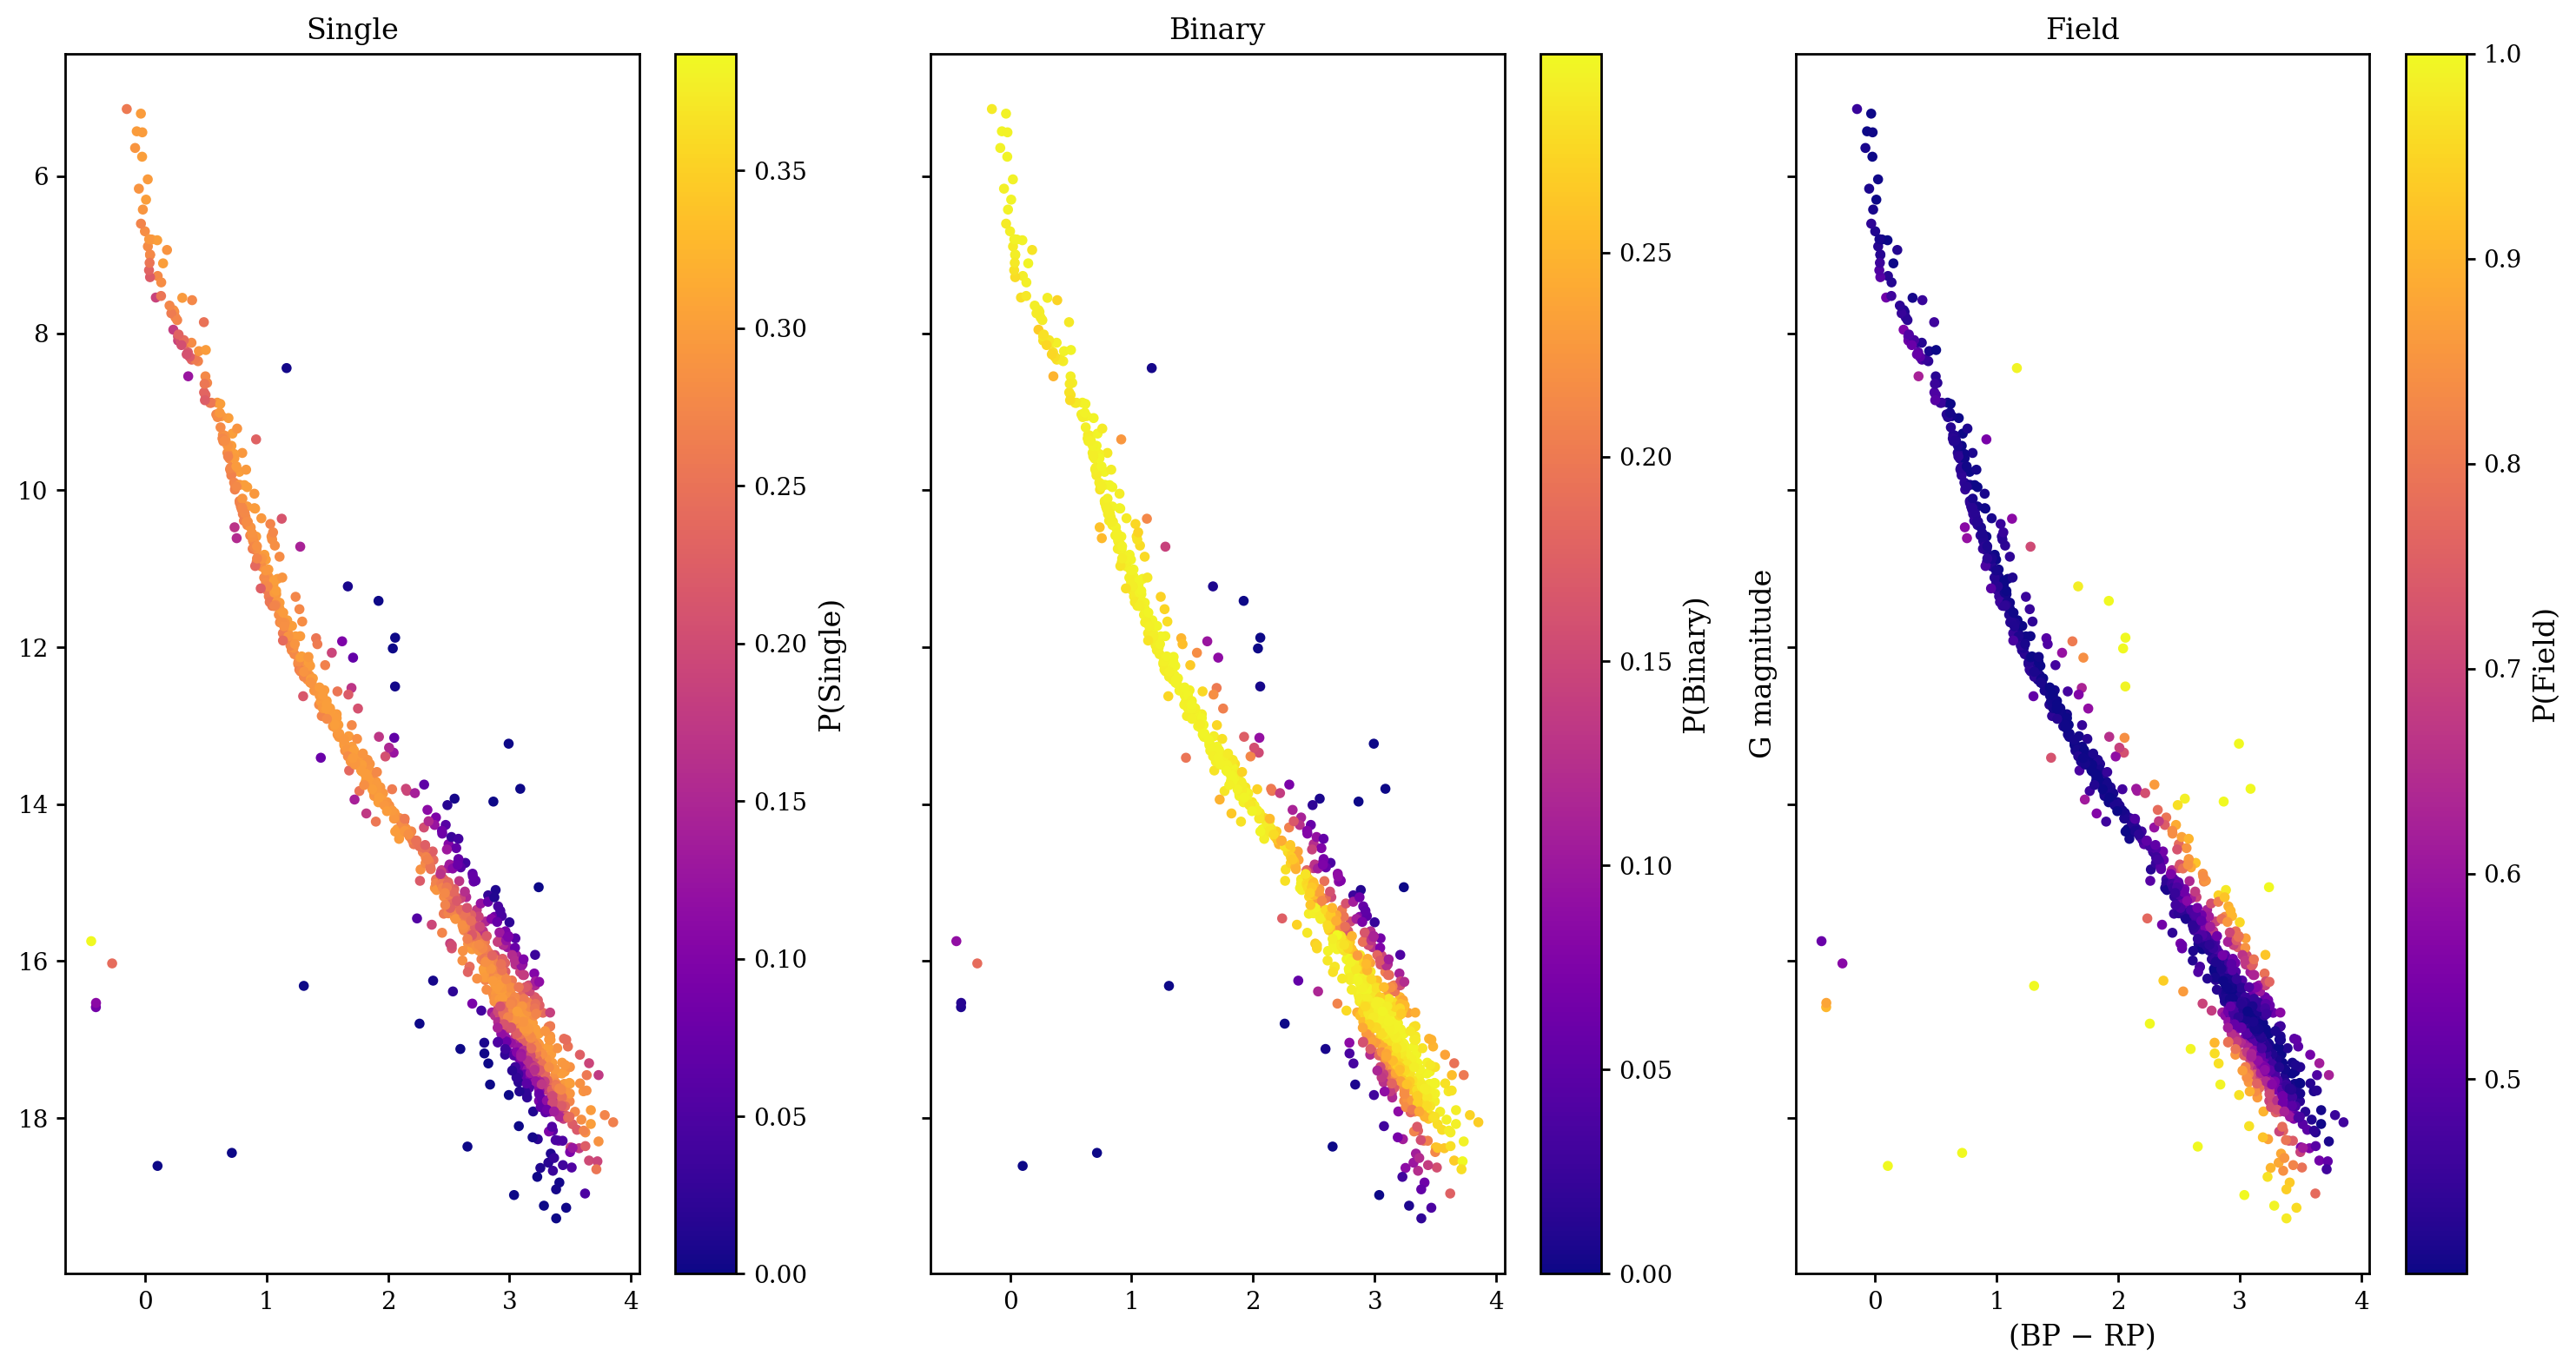

In [18]:
import matplotlib.pyplot as plt

R = binary_fitter.E_step(binary_fitter.theta)
labels = ["Single", "Binary", "Field"]
colors = [R[:,0], R[:,1], R[:,2]]

fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharex=True, sharey=True)
for ax, c, lbl in zip(axes, colors, labels):
    sc = ax.scatter(binary_fitter.BP - binary_fitter.RP, binary_fitter.G,
                    c=c, cmap="plasma", s=10)
    ax.invert_yaxis()
    ax.set_title(lbl)
    plt.colorbar(sc, ax=ax, label=f"P({lbl})")
plt.xlabel("(BP − RP)")
plt.ylabel("G magnitude")
plt.tight_layout()
plt.show()


In [19]:
import generator.synthesizer

In [22]:
from generator import IsochroneSynthesizer

synthesizer = IsochroneSynthesizer()
df = synthesizer.generate(1000)

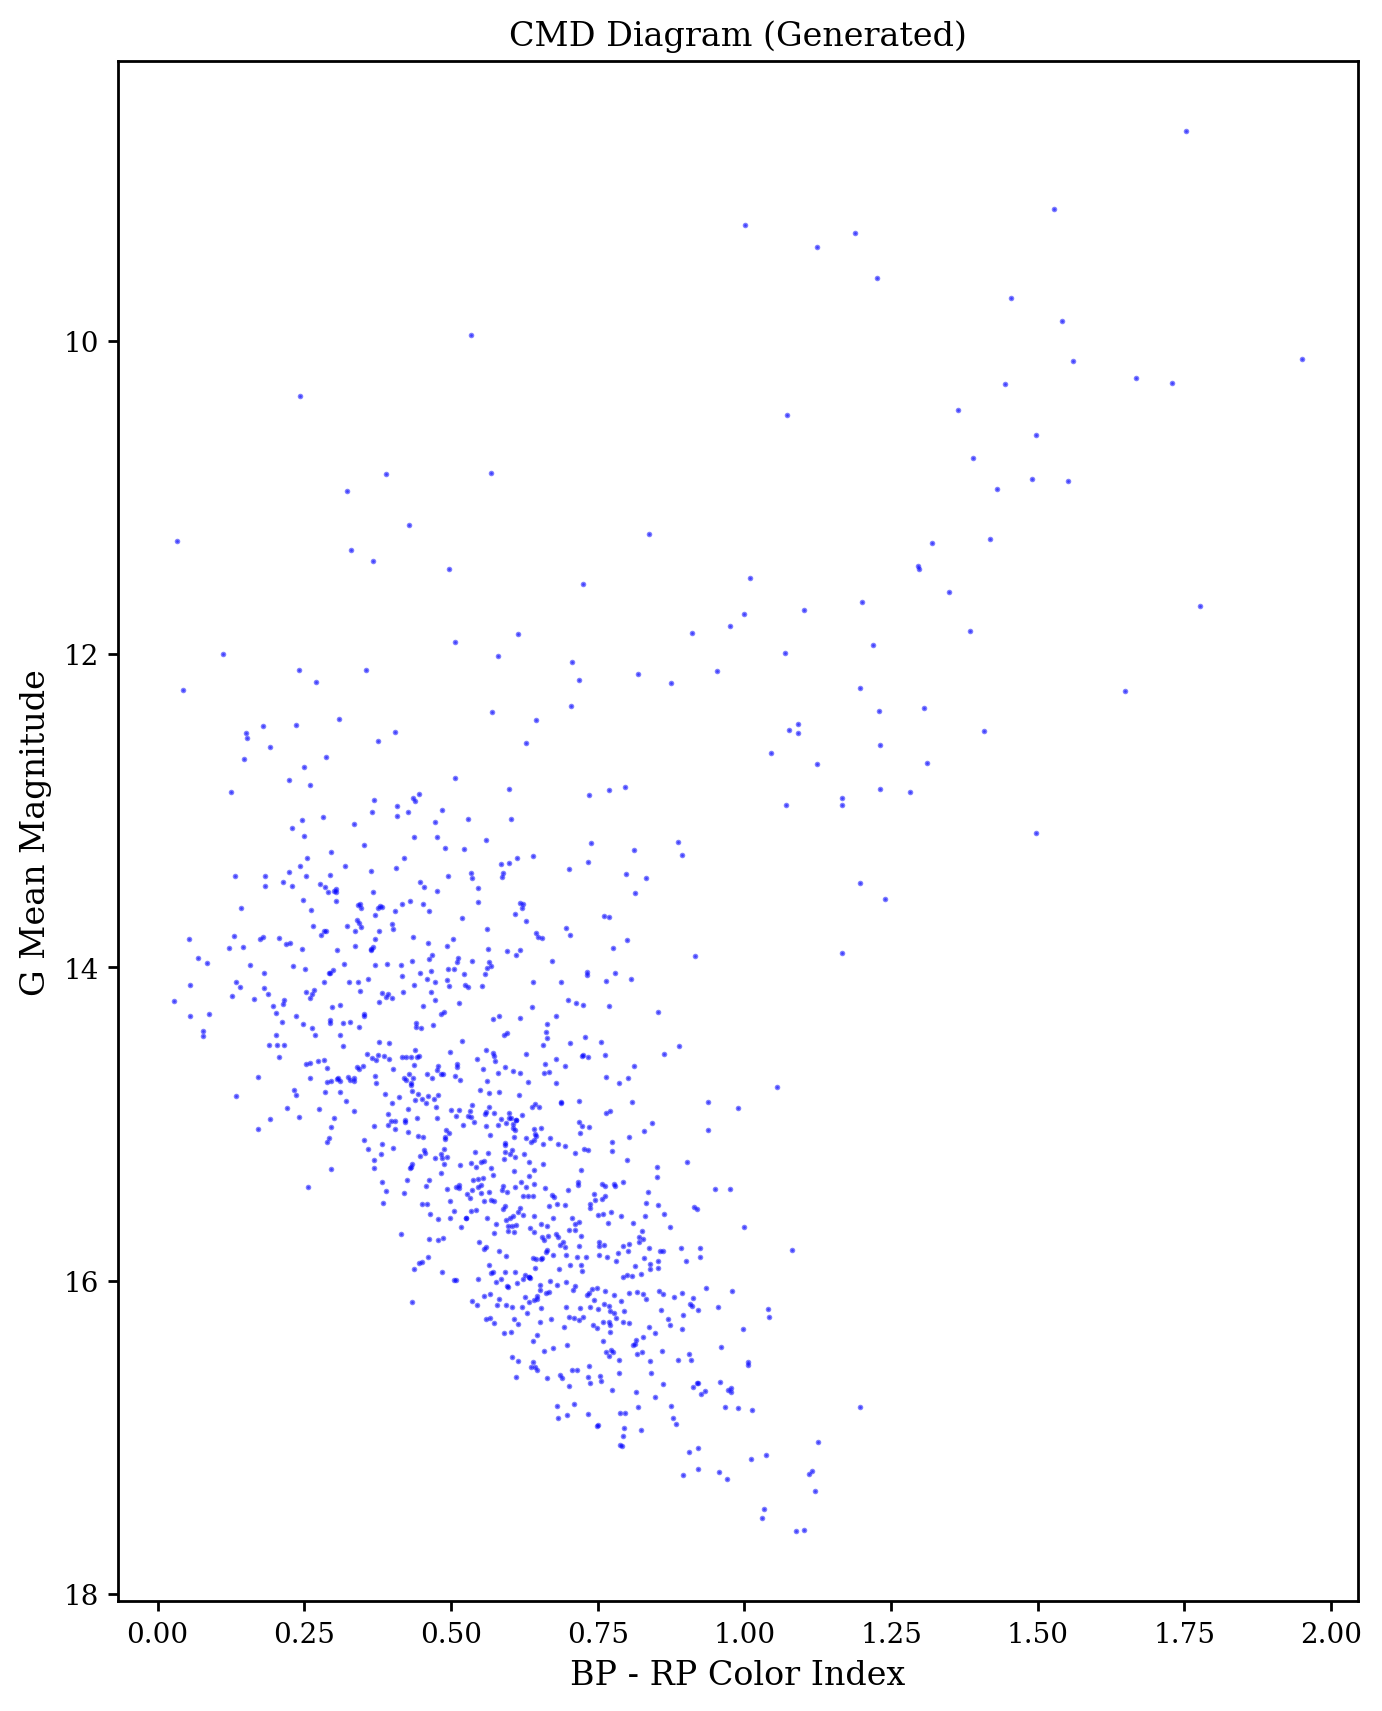

(<Figure size 800x1000 with 1 Axes>,
 <Axes: title={'center': 'CMD Diagram (Generated)'}, xlabel='BP - RP Color Index', ylabel='G Mean Magnitude'>)

In [21]:
synthesizer.plot_hr_diagram()

In [26]:
synthetic_fitter = MISTFitter(data=df, age_range=(70e6, 160e6))

In [27]:
synthetic_sampler = fitter.sample_cluster(n_walkers=32, n_burn=200, n_steps=2000)

emcee: Exception while calling your likelihood function:
  params: [ 9.93792638e+07 -3.86928665e-01  1.29450599e+02  5.93141495e-01
 -1.19973240e-01 -5.62497388e-02]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/jeremyng/conda/envs/iso_arm/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/jeremyng/Desktop/Yale/7 - FALL 2025/ASTR 365 - Astrostatistics/binary/analyzer/mist_fitter.py", line 178, in ln_posterior
    ll = self.ln_likelihood(theta)
  File "/Users/jeremyng/Desktop/Yale/7 - FALL 2025/ASTR 365 - Astrostatistics/binary/analyzer/mist_fitter.py", line 162, in ln_likelihood
    rC, rM, sC, sM = self._compute_residuals(theta)
  File "/Users/jeremyng/Desktop/Yale/7 - FALL 2025/ASTR 365 - Astrostatistics/binary/analyzer/mist_fitter.py", line 132, in _compute_residuals
    sG  = np.nan_to_num(self.data.get("G_mag_unc",  np.full_like(G,  self._sG_med )).to_numpy(),  nan=self._sG_med)
AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'


AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [ ]:
# Step 5: plot best model
best_params = fitter.get_best_model()
print(f"Best cluster parameters:\nAge={median_params[0]:.2e} yr, [Fe/H]={median_params[1]:.2f}, "
      f"Distance={median_params[2]:.1f} pc, A_V={median_params[3]:.2f}")

# Step 4: Plot median
fitter.plot_isochrone(best_params)